# **Laporan Proyek Machine Learning - William Devin Septianus Pranggono**

## **Import Libraries**

In [1]:
!pip install datasets faiss-cpu pinyin mecab-python3 unidic-lite cutlet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 38.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 57.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.3/695.3 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.7/205.7 kB 15.7 MB/s eta 0:00:00
  Created wheel for pinyin: filename=pinyin-0.4.0-py3-none-any.whl size=3630476 sha256=5d56370a6e87a0073c8d93a8e6f6973119f80ce6080da93c3cf7e55a5c96d859
  Stored in directory: /root/.cache/pip/wheels/1c/f5/31/ac8c91eccb570a59fe5f1471ad9f11bece8f4fd4be1ab1be25
  Created wheel for unidi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import datasets
import os
from zipfile import ZipFile
import regex as re
import html
import pinyin
import cutlet
import unicodedata
import requests
import json
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
import dateutil
import time

2025-11-12 11:07:05.001992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762945625.235433      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762945625.298791      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
if tf.config.list_logical_devices('TPU') :
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
elif tf.config.list_logical_devices('GPU') :
    strategy = tf.distribute.MirroredStrategy()
else :
    strategy = tf.distribute.get_strategy()

I0000 00:00:1762945639.325593      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762945639.326253      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## **Domain Proyek**

### **Latar Belakang**

Dengan berkembangnya media sosial dan internet sebagai sarana penyampaian informasi dan konten, sistem rekomendasi menjadi salah satu faktor yang penting untuk memastikan konten diberikan kepada sasaran pengguna yang tepat. Sistem rekomendasi dapat menguntungkan kedua belah pihak : penyedia produk/layanan dan pengguna. Sistem rekomendasi dapat meningkatkan engagement pengguna sehingga dapat meingkatkan retensi dan loyalitas pelanggan terhadap layanan. Di sisi lain, pengguna juga diuntungkan karena layanan tersebut dapat merekomendasikan produk atau konten yang sesuai dengan kebutuhan atau minat dari pelanggan.

Buku merupakan sumber informasi dengan berbagai tujuan, seperti ilmu pengetahuan, hiburan, dokumentasi, dan sebagainya. Dengan jumlah buku yang banyak dan genre yang bervariasi, maka diperlukan sistem rekomendasi yang dapat memberikan rekomendasi buku yang tepat kepada para pembaca.

### **Referensi (Additional Rubric)**

#### Mengapa Masalah ini Penting

Buku merupakan salah satu sumber bacaan dengan tujuan beragam seperti riset akademik, fiksi, novel, komik, dan sebagainya. Perkembangan internet saat ini turut menciptakan format buku elektronik, sehingga meningkatkan aksesibilitas pengguna dalam membaca buku. Sebagai gambaran, Google Play Books, salah satu aplikasi yang menyediakan e-book berbayar atau gratis, memiliki jumlah download lebih dari 1 miliar pengguna, dengan rating 4.8. Data tersebut menunjukkan bahwa buku masih diminati oleh banyak orang.

Menurut Akbar *et al.* (2023), di masa sekarang terdapat banyak orang yang merasa kesulitan dalam membeli buku yang sesuai keinginan mereka, sehingga membuat kesalahan dalam membeli buku. Hal tersebut disebabkan semakin banyaknya buku yang diterbitkan dan ragam genre buku yang banyak. Oleh karena itu, diperlukan sebuah sistem rekomendasi yang dapat memberikan rekomendasi yang relevan bagi pengguna.

#### Daftar Pustaka

[1] Akbar, R., Richasdy, D. and Dharayani, R., 2023. Sistem Rekomendasi Buku Dengan Collaborative Filtering Menggunakan Metode Singular Value Decomposition (SVD). eProceedings of Engineering, 10(5).

[2] [Google Play Books - Google Play Store](https://play.google.com/store/apps/details?id=com.google.android.apps.books&hl=en&pli=1)

## **Business Understanding**

### **Problem Statements**

* Berdasarkan data buku, bagaimana membuat sistem rekomendasi buku dengan teknik content-based filtering?
* Berdasarkan data rating dan data demografi pengguna, bagaimana cara membuat rekomendasi buku dengan teknik collaborative filtering?
* Bagaimana attention mechanism diterapkan pada model collaborative filtering?

### **Goals**

* Menghasilkan recommender system content-based filtering yang dapat merekomendasikan buku berdasarkan atribut-atributnya.
* Menghasilkan recommender system berbasis collaborative filtering dengan attention mechanism yang dapat memberikan rekomendasi buku yang belum pernah dibaca oleh pengguna berdasarkan data pengguna, data buku, dan data rating.

### **Solution Statements (Additional Rubric)**

* Menggunakan TF-IDF Vectorizer dan Cosine Similarity untuk membuat sistem rekomendasi content-based.
* Menggunakan model deep learning untuk membuat model sistem rekomendasi berbasis collaborative filtering.

## **Data Understanding**

### **Tentang Dataset**

Dataset ini dikumpulkan oleh Cai-Nicolas Ziegler dalam waktu 4 minggu (Agustus 2004 - September 2004) dari Book Crossing Community dengan izin dari Ron Hornbaker, CTO dari Humankind Systems. Dataset ini mengandung 278,858 record users anonim dengan informasi demografis, menyediakan 1,149,780 ratings (eksplisit dan implisit) terhadap 271,379 buku.

Sumber : [Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

### **Variabel-Variabel yang Digunakan pada Dataset**

1. File Books.CSV :
* ISBN : Kode ISBN Buku
* Book-Title : Judul Buku
* Book-Author : Penulis Buku
* Year-of-Publication : Tahun Terbit
* Publisher : Penerbit Buku
* Image-URL-S : Link Gambar Buku Ukuran Kecil
* Image-URL-M : Link Gambar Buku Ukuran Medium
* Image-URL-L : Link Gambar Buku Ukuran Besar

2. File Users.CSV :
* User-ID : ID User
* Location : Lokasi Domisili User
* Age : Usia User

3. File Ratings.CSV :
* User-ID : ID User
* ISBN : Kode ISBN Buku
* Book-Rating : Ulasan Buku dengan skala 1-10 untuk eksplisit, dan 0 untuk implisit.

### **Data Analysis (Additional Rubric)**

#### **Import Data**

In [3]:
books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
users = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv')
ratings = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv')

/tmp/ipykernel_36/2910231406.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')


#### **Data Inspection**

In [4]:
# Info Tabel Books
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Tipe data Year-Of-Publication seharusnya bertipe data integer. Dapat dilihat bahwa terdapat beberapa nilai null pada kolom Book-Author, Publisher, dan Image-URL-L. Nilai null berjumlah sedikit, sehingga dapat diatasi secara manual.

In [5]:
# Info Tabel Users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Dapat dilihat bahwa terdapat banyak nilai null pada kolom Age.

In [6]:
# Info Tabel Ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Berdasarkan info diatas, tidak terdapat nilai null pada tabel ratings.

In [7]:
# Deskripsi Tabel Books
books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


Karena freq = 1 (kemunculan paling banyak), maka dapat disimpulkan tidak terdapat data duplikat pada tabel Books.

In [8]:
# Deskripsi Tabel Users
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


Terdapat anomali pada usia user yang mencapai 244.

In [9]:
# Deskripsi Tabel Ratings
ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


Tidak terdapat anomali pada data tabel Ratings.

#### **Data Cleaning**

##### **Data Noise : Lokasi User**

###### **Membersihkan Dua Tanda Koma**

In [10]:
users[users['Location'].str.contains(',,')]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
2238,2239,"deep river,, connecticut, usa",25.0
4468,4469,"guadalajara,, jalisco, mexico, mexico",36.0
4634,4635,"san jose, la uruca,, costa rica",32.0
5412,5413,"ranfurly,, central otago, new zealand",54.0
5998,5999,"victoria,, british columbia, canada",NaN
...,...,...,...
272483,272484,"amora, estremadura,, portugal",1.0
272881,272882,"silver spring,, maryland, usa",50.0
275021,275022,"berkeley,, california, usa",NaN
275654,275655,"xiongcountry,, hebei, china",19.0


In [11]:
users['Location'] = users['Location'].str.replace(',,', ',')

###### **Menerjemahkan HTML Escape Code**

In [12]:
users[users['Location'].str.contains(r'[&;]')]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
5261,5262,"&#304;zmir, n/a, turkey",27.0
8195,8196,"auck;and, auckland, new zealand",18.0
9310,9311,"&#321;ód&#378;, lodzkie, poland",17.0
9925,9926,"tyne&wear, england, united kingdom",36.0
10661,10662,"nanchong, &#22235;&#24029;, china",NaN
...,...,...,...
277335,277336,"&#40784;&#40784;&#21704;&#23572;&#24066;, west...",24.0
277446,277447,"aleksinac, serbia & montenegro, yugoslavia",NaN
277490,277491,"&#21271;&#20140;, &#24191;&#35199;, china",18.0
278077,278078,"&#20029;&#27743;, &#20013;&#22269;-&#20113;&#2...",NaN


In [30]:
def translate_html(value) :
    try :
        if re.search(r'[&;]', value) :
            translated = html.unescape(value)
            return pinyin.get(translated, format='strip', delimiter='')
    except Exception as e :
        return value
    return value

In [14]:
users['Location'] = users['Location'].apply(translate_html)

###### **Menormalisasi Accent Abjad**

In [31]:
def remove_diacritics(input_str):
    input_str = input_str.replace('ø', 'o')
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([char for char in nfkd_form if not unicodedata.combining(char)])

In [16]:
users['Location'] = users['Location'].apply(remove_diacritics)

###### **Menghilangkan Angka**

In [17]:
users[users['Location'].str.contains(r'[\d]')]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
251,252,"13001 safat, kuwait, kuwait",65.0
318,319,"1407 kobenhavn k, n/a, denmark",32.0
1253,1254,"16605 bennington ct, indiana, usa",26.0
1667,1668,"21000 split, n/a, croatia",NaN
2014,2015,"46487 wesel, nordrhein-westfalen, germany",NaN
...,...,...,...
277449,277450,"wuzhishan, 19, china",NaN
277717,277718,"colorado springs, co 80901, colorado, usa",62.0
277854,277855,"china.hubei.zhijiang, 563, china",18.0
278333,278334,"22, australian capital territory, australia",NaN


In [18]:
users['Location'] = users['Location'].str.replace(r'[\d]', '', regex=True)

In [19]:
users['Location'] = users['Location'].apply(lambda x: 'zhijiang, hubei, china' if re.search('hubei', x) else x)

###### **Membersihkan nilai n/a**

In [20]:
users[users['Location'].str.contains('n/a')]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
30,31,"shanghai, n/a, china",20.0
36,37,"san sebastian, n/a, spain",23.0
44,45,"berlin, n/a, germany",NaN
64,65,"n/a, n/a, australia",NaN
73,74,"amsterdam, n/a, netherlands",30.0
...,...,...,...
278781,278782,"larnaca, n/a, cyprus",NaN
278787,278788,"zuerich, n/a, switzerland",NaN
278807,278808,"esplugas de llobregat, n/a, spain",43.0
278852,278853,"stranraer, n/a, united kingdom",17.0


In [21]:
users['Location'] = users['Location'].str.replace('n/a', '')
users['Location'] = users['Location'].str.replace('none', '')

###### **Membersihkan Non-Karakter**

In [22]:
mask = users['Location'].apply(lambda x: bool(re.search(r'[^-,\s\p{N}\p{L}]', x)))
users.loc[mask]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
3,4,"porto, v.n.gaia, portugal",17.0
20,21,"ferrol / spain, alabama, spain",46.0
90,91,"toronto/newmarket, ,",NaN
110,111,"avintes, v.n. gaia, portugal",25.0
111,112,"mexico city, d.f., mexico",32.0
...,...,...,...
278785,278786,"st. catharines, ontario, canada",NaN
278793,278794,"st. paul, minnesota, usa",14.0
278810,278811,"±±⁄©, ±±⁄©, china",19.0
278840,278841,"llangollen, denbighshire county, united kingdom.",NaN


In [23]:
users['Location'] = users['Location'].apply(lambda x: re.sub(r'[^&,-\s\p{N}\p{L}]', ' ', x))

In [24]:
mask = users['Location'].apply(lambda x: bool(re.search(r'[^&-,\s\p{N}\p{L}]', x)))
users.loc[mask]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
27,28,"freiburg, baden-wuerttemberg, germany",24.0
45,46,"heidelberg, baden-wuerttemberg, germany",31.0
125,126,"eindhoven, noord-brabant, netherlands",24.0
139,140,"kappelrodeck, baden-wuerttemberg, germany",24.0
157,158,"nufringen, baden-wuerttemberg, germany",38.0
...,...,...,...
278730,278731,"stuttgart, baden-wurttemberg, germany",NaN
278763,278764,"herzerock-clarholz, nrw, germany",NaN
278777,278778,"koln, nordrhein-westfalen, germany",42.0
278784,278785,"gustow, mecklenburg-vorpommern, germany",16.0


In [25]:
users[users['Location'].str.contains('[-]{2,}')]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,User-ID,Location,Age
2516,2517,"judendorf-straßengel, styria--austria, austria",NaN
14660,14661,"------, -------, -------",NaN
14877,14878,"--, west indies, trinidad & tobago",NaN
27748,27749,"-----, limburg, netherlands",24.0
44366,44367,"athens, ------------, greece",NaN
53273,53274,"-----, virginia, usa",NaN
65979,65980,"lagos, lagos---nigeria, nigeria",32.0
86961,86962,"---, ----, egypt",25.0
101836,101837,"a a a a, a a a a a a a a a aoe a...",21.0
104349,104350,"istanbul, --, turkey",NaN


In [26]:
users['Location'] = users['Location'].str.replace(r'[-]{2,}', '', regex=True)

In [27]:
users[users['Location'].str.contains(r'[-]{2,}')]

,User-ID,Location,Age


###### **Memecah Lokasi menjadi Kota, Provinsi, dan Negara**

In [28]:
def split_location(loc) :
    loc_arr = loc.split(',')
    loc_arr = [s.strip() for s in loc_arr]
    loc_arr = [s if s != '' else 'unknown' for s in loc_arr]

    if len(loc_arr) > 3 :
        loc_arr = loc_arr[0:1] + loc_arr[-2:]
    elif len(loc_arr) < 3 :
        loc_arr = loc_arr + ['unknown']*(3 - len(loc_arr))
    return loc_arr[0], loc_arr[1], loc_arr[2]

In [29]:
users[['City', 'Province', 'Country']] = users['Location'].apply(lambda x: pd.Series(split_location(x)))

###### **Memperbaiki Inkonsistensi Penamaan Negara**

In [30]:
users['Country'] = users['Country'].apply(lambda x: 'usa' if re.search('usa|united state|unite states', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'uk' if re.search(r'united kingdom|england|scotland|wales|northern ireland', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'france' if re.search('france', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'italy' if re.search('itali|italy', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'germany' if re.search('deutschland', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'uruguay' if re.search('urugua', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'spain' if re.search('espana', x) else x)
users['Country'] = users['Country'].apply(lambda x: 'uae' if re.search('emirate', x) else x)

###### **Memperbarui Nilai Location**

In [31]:
users['Location'] = users['City'] + ", " + users['Province'] + ", " + users['Country']

##### **Data Noise : Usia User**

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


<Axes: >

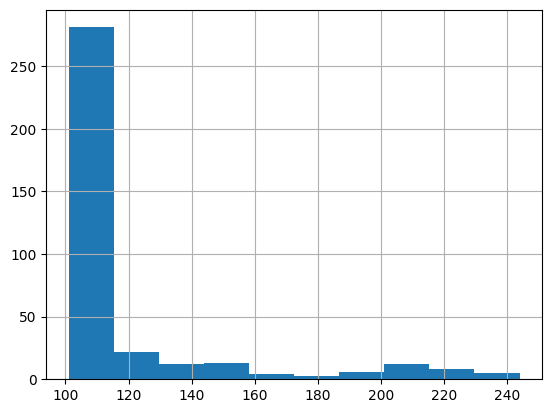

In [32]:
users[users['Age'] > 100]['Age'].hist()

Pada pengguna dengan usia lebih besar dari 100, jumlah pengguna dengan usia 101-110 adalah yang paling banyak, sehingga batas usia 110 akan ditetapkan sebagai threshold untuk usia di atas angka tersebut.

In [33]:
users.loc[users['Age'] > 110, 'Age'] = 110

In [34]:
users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.722688
std,80499.51502,14.192125
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,110.000000


<Axes: >

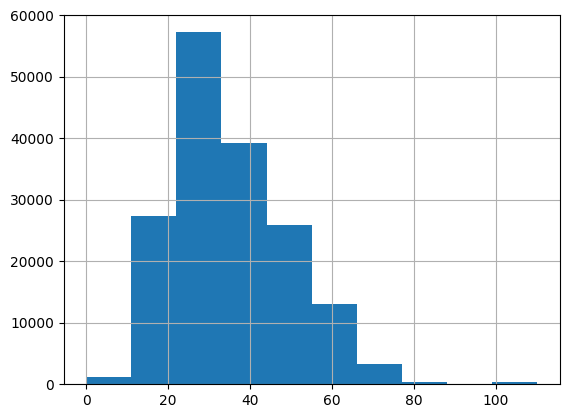

In [35]:
users['Age'].hist()

##### **Data Noise : Books**

###### **Shift / Geser Kolom pada Beberapa Baris di Tabel Books**

In [36]:
books[books['Year-Of-Publication'].astype('str').str.contains(r'[^\d]')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


Terdapat kesalahan pada 3 record yang menggabungkan judul buku dan nama penulis.

In [37]:
books.loc[books['Year-Of-Publication'].astype('str').str.contains(r'[^\d]'), 'Book-Title'].values

array(['DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\\";Michael Teitelbaum"',
       'Peuple du ciel, suivi de \'Les Bergers\\";Jean-Marie Gustave Le ClÃ?Â©zio"',
       'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\\";James Buckley"'],
      dtype=object)

In [38]:
books.loc[books['Year-Of-Publication'].astype('str').str.contains(r'[^\d]'), 'Book-Author':] = \
books.loc[books['Year-Of-Publication'].astype('str').str.contains(r'[^\d]'), 'Book-Author':].shift(1, axis=1)

In [39]:
books.loc[books['ISBN'] == '078946697X', ['Book-Title', 'Book-Author']] =\
['DK Readers: Creating the X-Men, How It All Began (Level 4 Proficient Readers)', 'Michael Teitelbaum']
books.loc[books['ISBN'] == '2070426769', ['Book-Title', 'Book-Author']] =\
['Peuple du ciel suivi de Les Bergers', 'Jean-Marie Gustave Le Clézio']
books.loc[books['ISBN'] == '0789466953', ['Book-Title', 'Book-Author']] =\
['DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4 Proficient Readers)', 'James Buckley']

###### **Tahun Publikasi**

In [40]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype('int64')

In [41]:
books.describe()

,Year-Of-Publication
count,271360.000000
mean,1959.761273
std,257.992836
min,0.000000
25%,1989.000000
50%,1995.000000
75%,2000.000000
max,2050.000000


Anomali pada tahun terbit adalah nilai minimum 0 dan nilai maksimum 2050, yang melebihi tahun maksimal saat data dikumpulkan, yaitu 2004.

###### **Keberadaan Non-Karakter pada Kolom Book-Author dan Book-Title**

In [42]:
mask = books[['Book-Title', 'Book-Author', 'Publisher']].apply(lambda x: x.str.contains(r'[^\w\s\'\.\-,&()\:]', na=False))
books.loc[mask.any(axis=1)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
21,1841721522,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd,http://images.amazon.com/images/P/1841721522.0...,http://images.amazon.com/images/P/1841721522.0...,http://images.amazon.com/images/P/1841721522.0...
22,1879384493,If I'd Known Then What I Know Now: Why Not Lea...,J. R. Parrish,2003,Cypress House,http://images.amazon.com/images/P/1879384493.0...,http://images.amazon.com/images/P/1879384493.0...,http://images.amazon.com/images/P/1879384493.0...
23,0061076031,Mary-Kate &amp; Ashley Switching Goals (Mary-K...,Mary-Kate &amp; Ashley Olsen,2000,HarperEntertainment,http://images.amazon.com/images/P/0061076031.0...,http://images.amazon.com/images/P/0061076031.0...,http://images.amazon.com/images/P/0061076031.0...
...,...,...,...,...,...,...,...,...
271334,3548740146,Wicca. Eine EinfÃ?Â¼hrung in weiÃ?Â?e Magie.,Scott Cunningham,2001,"Ullstein TB-Vlg., B.",http://images.amazon.com/images/P/3548740146.0...,http://images.amazon.com/images/P/3548740146.0...,http://images.amazon.com/images/P/3548740146.0...
271335,381440176X,"Ein Fall fÃ?Â¼r TKKG, Bd.50, Sklaven fÃ?Â¼r Wu...",Stefan Wolf,1989,Pelikan,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...
271344,2268032019,Petite histoire de la dÃ?Â©sinformation,Vladimir Volkoff,1999,Editions du Rocher,http://images.amazon.com/images/P/2268032019.0...,http://images.amazon.com/images/P/2268032019.0...,http://images.amazon.com/images/P/2268032019.0...
271345,0684860112,Driving to Detroit: Memoirs of a Fast Woman,Lesley Hazleton,1999,Simon &amp; Schuster (Trade Division),http://images.amazon.com/images/P/0684860112.0...,http://images.amazon.com/images/P/0684860112.0...,http://images.amazon.com/images/P/0684860112.0...


Data *noise* lainnya adalah terdapat non-karakter pada Book-Title, Book-Author, dan Publisher.

Perbaikan nilai-nilai *noise* pada kolom Book-Title, Year-Of-Publication, Book-Author, dan Publisher akan dilakukan dengan mengambil data dari sumber lain, yaitu OpenLibrary API.

In [43]:
merged_isbn_null = pd.merge(left=books, right=ratings, on='ISBN', how='outer')\
[lambda x: x['Book-Title'].isna()]['ISBN']
merged_isbn_null.nunique()

70405

Terdapat 70.405 buku yang memiliki ratings, namun tidak terdapat pada tabel Books. Oleh karena itu, data ISBN dari buku-buku tersebut akan ditambahkan pada tabel Books menggunakan OpenLibrary API.

Karena pemerolehan data buku menggunakan ISBN, maka harus dipastikan bahwa ISBN memiliki format yang sesuai, yaitu terdiri dari 10 digit dan hanya dapat mengandung angka 0-9 serta huruf X. *Dataset* juga memiliki ISBN dengan nilai seperti B0000BLD7X yang merupakan Amazon Standard Identification Number (ASIN). Data dengan nilai ASIN pada ISBN akan dipertahankan, karena terdapat data ratings terkait. Melakukan *dropping* data berpotensi menghilangkan informasi. *Dropping* akan dipertimbangkan apabila data buku tidak ditemukan setelah dilakukan pencarian pada API.

In [44]:
def clean_isbn(isbn) :
    isbn = isbn.upper()
    if re.search(r'[^0-9A-Z]', isbn) :
        isbn_valid = re.search(r'\d{10}|\d{9}X', isbn)
        if not isbn_valid :
            isbn = re.sub(r'[^A-Z0-9]', '', isbn)
        else :
            isbn = isbn_valid.group()
    
    return isbn

In [45]:
books = \
books = pd.concat([
    books,
    pd.Series(merged_isbn_null.unique(),
              name='ISBN'
             )
], axis=0)

In [46]:
books['ISBN'] = books['ISBN'].apply(clean_isbn)

In [47]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].fillna(0)

In [48]:
def get_books_attributes(books_batch) :
    ISBNs = ','.join([f'ISBN:{book["ISBN"]}' for book in books_batch])
    response = requests.get(f'https://openlibrary.org/api/books?bibkeys={ISBNs}&format=json&jscmd=data')
    books_data = json.loads(response.content)

    updated_books_data = []

    for book in books_batch :
        book_data = books_data.get(f'ISBN:{book["ISBN"].strip()}', {})

        author = ''
        publisher = ''
        authors_arr = []
        publishers_arr = []

        if 'publish_date' in book_data.keys() and (int(book['Year-Of-Publication']) < 1400 or int(book['Year-Of-Publication']) > 2004) :
            try :
                year = dateutil.parser.parse(book_data['publish_date']).year
            except Exception as e :
                year = int(book['Year-Of-Publication'])
        else :
            year = int(book['Year-Of-Publication'])
        year = year if 1400 <= year <= 2004 else 0

        title = book_data.get('title', book['Book-Title']) or book['Book-Title']

        authors = book_data.get('authors', [{'name': book['Book-Author']}])
        if len(authors) > 1 :
            for author_data in authors :
                authors_arr.append(author_data['name'])
            author = ", ".join(authors_arr)
        else :
            author = authors[0].get('name', '') or book['Book-Author']

        publishers = book_data.get('publishers', [{'name': book['Publisher']}])

        if len(publishers) > 1 :
            for publisher_data in publishers :
                publishers_arr.append(publisher_data['name'])
                publisher = ", ".join(publishers_arr)
        else :
            publisher = publishers[0].get('name', '') or book['Publisher']

        title = remove_diacritics(title) if type(title) is str else title
        author = remove_diacritics(author) if type(author) is str else author
        publisher = remove_diacritics(publisher) if type(publisher) is str else publisher
        
        book_data = [title, author, year, publisher]
        updated_books_data.append(book_data)

    return updated_books_data

In [49]:
batches = []
for i in range(0, len(books), 100) :
    batches.append(books.iloc[i:i+100, :].to_dict('records'))

In [50]:
results = []
with ThreadPoolExecutor(max_workers=8) as executor :
    futures = [executor.submit(get_books_attributes, batch) for batch in batches]
    for future in futures :
        results += future.result()

In [51]:
len(results)

341765

In [52]:
books[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']] = results
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype('int64')

In [53]:
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])

##### **Penggunaan Karakter Hanzi**

In [54]:
books[~(books.isna().any(axis=1))].sort_values('Book-Title')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
100520,1563892650,"Summonings: Books of Magic, Vol. 2",John Ney Rieber,1996,DC Comics
154078,0394721837,The wounded woman healing the father-daughte...,Linda Schierse Leonard,1983,"Shambhala, Shambhala, Distributed in the U.S...."
75637,1565920465,!%@:: a directory of electronic mail addressin...,"Donnalyn Frey, Rick Adams",1994,O'Reilly & Associates
156341,1565920317,!%@:: a directory of electronic mail addressin...,"Donnalyn Frey, Rick Adams",1993,O'Reilly & Associates
112917,0133989429,!Arriba! Comunicacion y cultura,"Eduardo Zayas-Bazan, Eduardo Zayas-Bazan, Jose...",1996,Prentice Hall
...,...,...,...,...,...
49468,7544210960,活着,余华,1998,南海出版公司
49443,7532718301,看得见风景的房间,E. M. Forster,1996,上海译文出版社
5808,957131577X,遇見100%的女孩,村上春樹,1995,Shi Bao
47896,4062551756,"風の万里 黎明の空 1 [Kaze no Banri, Reimei no Sora]",Fuyumi Ono,1994,White Heart


In [57]:
katsu = cutlet.Cutlet()

cols_with_hanzi = ['Book-Title', 'Book-Author', 'Publisher']

for col in cols_with_hanzi :
    books.loc[~(books[col].isna()) & (books[col].str.contains(r'[\u4E00-\u9FFF]')), col] =\
    books.loc[~(books[col].isna()) & (books[col].str.contains(r'[\u4E00-\u9FFF]')), col]\
    .apply(lambda x: pinyin.get(x, format='strip', delimiter=' '))
    books.loc[~(books[col].isna()) & (books[col].str.contains(r'[\u3040-\u30FF]')), col] =\
    books.loc[~(books[col].isna()) & (books[col].str.contains(r'[\u3040-\u30FF]')), col]\
    .apply(lambda x: katsu.romaji(x))

##### **HTML Escape Characters**

In [58]:
books[['Book-Title', 'Book-Author', 'Publisher']] = books[['Book-Title', 'Book-Author', 'Publisher']].map(translate_html)
books[['Book-Title', 'Book-Author', 'Publisher']] = books[['Book-Title', 'Book-Author', 'Publisher']].map(lambda x: x.replace('&amp;', '&'))

##### **Accents**

In [ ]:
books[['Book-Title', 'Book-Author', 'Publisher']] = books[['Book-Title', 'Book-Author', 'Publisher']].map(remove_diacritics)

##### **Data Noise : Ratings**

###### **ISBN**

In [60]:
ratings['ISBN'] = ratings['ISBN'].apply(clean_isbn)

##### **Null Values**

###### **Tabel Books**

In [61]:
books.loc[(books[['Book-Title', 'Book-Author', 'Publisher']].isna().all(axis=1)) & \
(books['Year-Of-Publication'] == 0)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
3,9022906116,NaN,NaN,0,NaN
4,9032803328,NaN,NaN,0,NaN
7,9044922718,NaN,NaN,0,NaN
8,9044923161,NaN,NaN,0,NaN
9,904492401X,NaN,NaN,0,NaN
...,...,...,...,...,...
70399,CN108465,NaN,NaN,0,NaN
70400,CN113107,NaN,NaN,0,NaN
70401,OOO7156103,NaN,NaN,0,NaN
70402,423350229,NaN,NaN,0,NaN


Terdapat 32.968 data buku yang bernilai kosong dan tidak ditemukan pada OpenLibrary API. Oleh karena itu, data-data tersebut akan di-*drop*.

In [62]:
books = books[~((books[['Book-Title', 'Book-Author', 'Publisher']].isna().all(axis=1)) & (books['Year-Of-Publication'] == 0))]

In [63]:
books.isna().sum()

ISBN                      0
Book-Title                8
Book-Author            3350
Year-Of-Publication       0
Publisher              1282
dtype: int64

In [64]:
books.loc[books['Book-Title'].isna(), 'ISBN'].values

array(['0852291485', '1880889145', '3596252040', '3811800906',
       '8421691783', '8422635593', '8422665816', '9780425143322'],
      dtype=object)

In [65]:
missing_book_titles = ['The Young Children\'s Encyclopedia',
                       'Baby Bop\'s Birthday',
                       'Ein Mann. Roman.',
                       'Kindertränen brennen heiß',
                       'Kika Superbruja en el castillo de Drácula',
                       'El corazón de piedra verde',
                       'Olvidado Rey Gudú',
                       'Without Remorse'
                      ]
books['Book-Title'] = books['Book-Title'].fillna({k: v for k,v in zip(
    books.loc[books['Book-Title'].isna()].index.tolist(),
    missing_book_titles
)})

In [28]:
def fill_missing_book_data(row) :
    author = row['Book-Author']
    publisher = row['Publisher']
    
    if pd.isna(author) :
        if pd.isna(publisher) :
            row['Book-Author'] = 'Unknown'
        else :
            row['Book-Author'] = publisher

    if pd.isna(publisher) :
        if pd.isna(author) :
            row['Publisher'] = 'Unknown'
        else :
            row['Publisher'] = author
    
    return row

In [29]:
books = books.apply(fill_missing_book_data, axis=1)

In [30]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

###### **Tabel Users**

In [69]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
City             0
Province         0
Country          0
dtype: int64

Nilai null pada kolom Age berjumlah cukup banyak, yaitu sebagian dari jumlah data.

In [70]:
users['Age Missing'] = users['Age'].isna()

missing_age_by_country = users.groupby('Country')['Age Missing']\
.agg(['sum', 'count'])\
.rename(columns={'sum': 'Missing', 'count': 'Total'})
missing_age_by_country['Ratio'] = missing_age_by_country['Missing'] / missing_age_by_country['Total']

missing_age_by_country.loc[missing_age_by_country['Total'] > 50].sort_values('Ratio', ascending=False).head(15)

,Missing,Total,Ratio
Country,,,
sweden,883,1456,0.606456
denmark,505,857,0.589265
slovenia,84,147,0.571429
south korea,128,225,0.568889
unknown,2612,4620,0.565368
taiwan,93,166,0.560241
italy,5919,11313,0.523203
netherlands,1570,3051,0.514585
iceland,27,55,0.490909


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


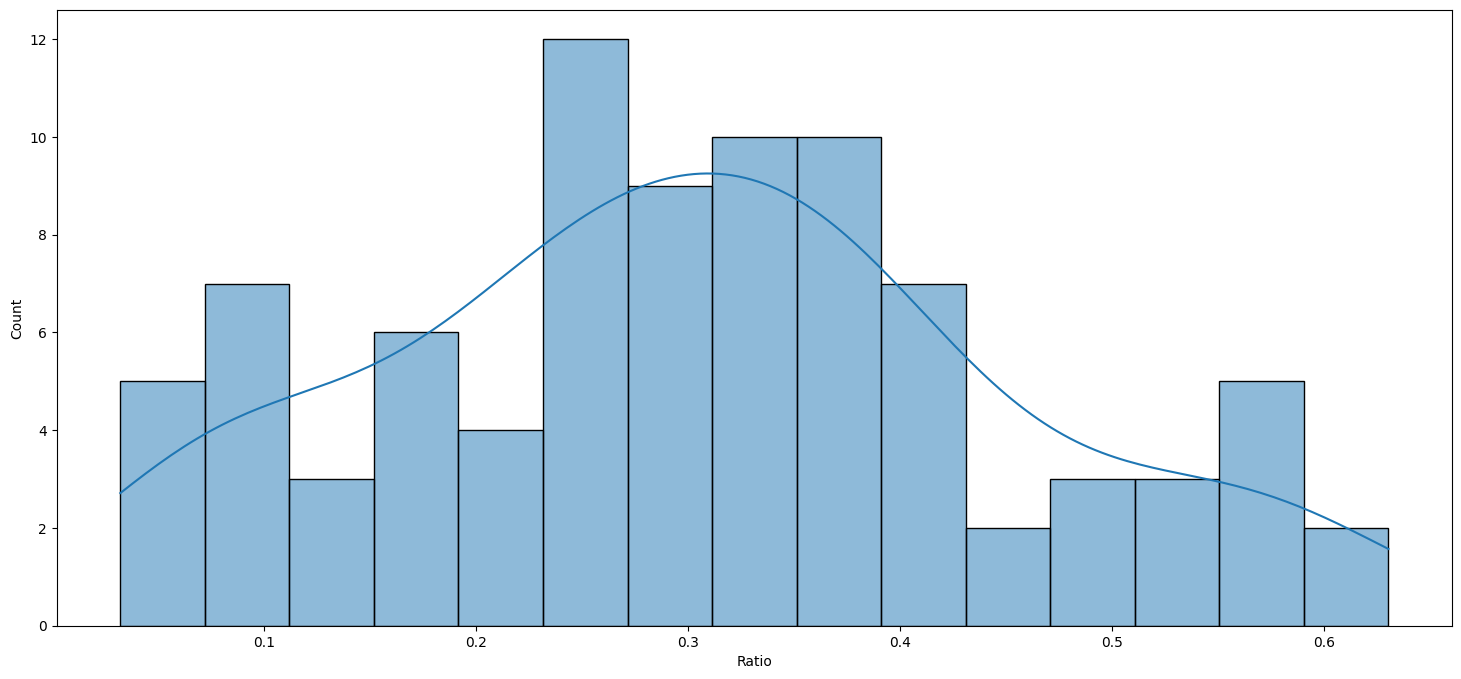

In [71]:
plt.figure(figsize=(18, 8))
sns.histplot(missing_age_by_country.loc[missing_age_by_country['Total'] >= 30, 'Ratio'],
             kde=True,
             bins=15
            )
plt.show()

Berdasarkan tabel tersebut, dapat disimpulkan bahwa nilai *null* Age memiliki rasio yang cukup besar terhadap total jumlah data berdasarkan negara. Melakukan imputasi pada fitur Age berpotensi untuk menggeser distribusi, mempengaruhi bias terhadap statistik usia pada setiap negara, dan menyebabkan *misleading* yang disebabkan jumlah data buatan yang berjumlah separuh dari jumlah total data. Oleh karena itu, nilai *null* tidak akan dibuang atau dilakukan imputasi statistik, namun akan direpresentasikan dengan -1 sebagai data kategorikal. Kemudian, untuk nilai numerik pada fitur Age akan dilakukan *binning*, yaitu pengelompokan usia dengan rentang tertentu.

In [72]:
users['Age'] = users['Age'].fillna(-1)

In [73]:
users.isna().sum()

User-ID        0
Location       0
Age            0
City           0
Province       0
Country        0
Age Missing    0
dtype: int64

###### **Tabel Ratings**

In [74]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Tidak terdapat null values pada tabel Ratings.

##### **Duplicated Data**

In [75]:
books.duplicated().sum()

588

In [76]:
books = books.drop_duplicates()
books.duplicated().sum()

0

In [77]:
users.duplicated().sum()

0

In [78]:
ratings.duplicated().sum()

8

In [79]:
ratings = ratings.drop_duplicates()
ratings.duplicated().sum()

0

#### **EDA dan Visualisasi**

##### **Univariate**

###### **Top 10 Author dengan Jumlah Buku Terbanyak**

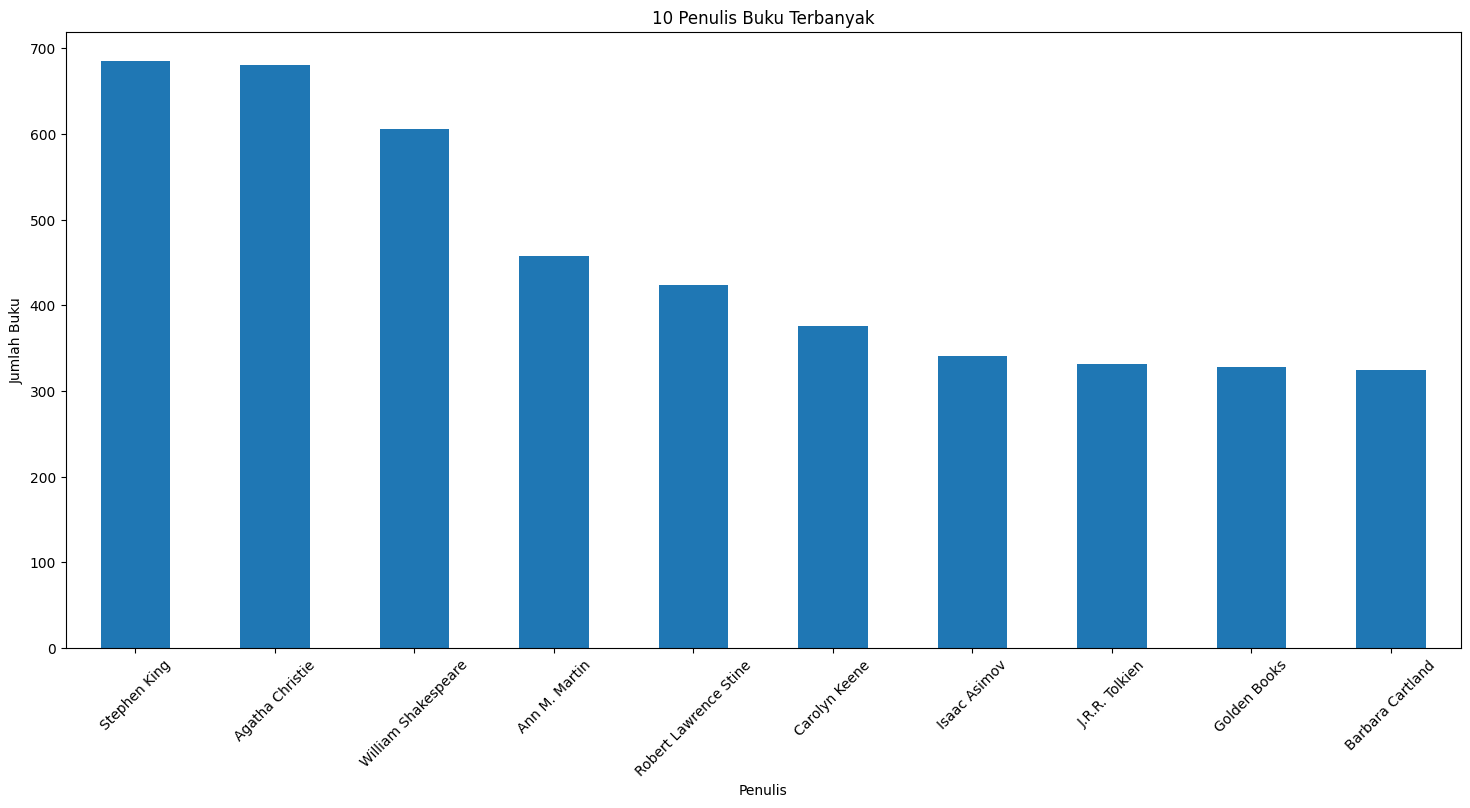

In [80]:
plt.figure(figsize=(18,8))
books.loc[books['Book-Author'] != 'Unknown', 'Book-Author'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('10 Penulis Buku Terbanyak')
plt.xticks(rotation=45)
plt.xlabel('Penulis')
plt.ylabel('Jumlah Buku')
plt.show()

Stephen King, Agatha Christie, dan William Shakespeare menulis paling banyak buku.

###### **Top 10 Publisher dengan Jumlah Buku Terbanyak**

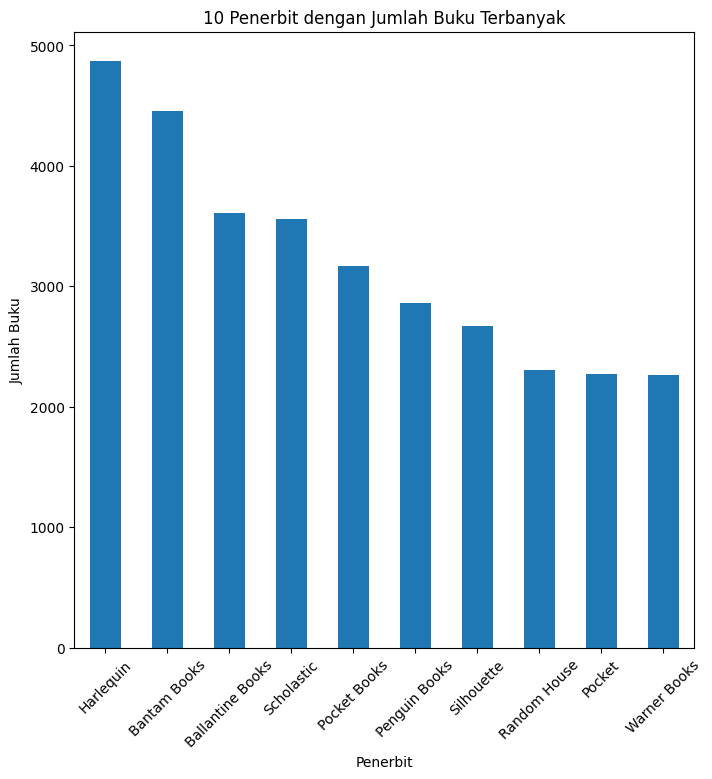

In [81]:
plt.figure(figsize=(8,8))
books.loc[books['Publisher'] != 'Unknown', 'Publisher'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('10 Penerbit dengan Jumlah Buku Terbanyak')
plt.xticks(rotation=45)
plt.xlabel('Penerbit')
plt.ylabel('Jumlah Buku')
plt.show()

Harlequin mendominasi penerbitan buku dengan hampir 5000 buku.

###### **Distribusi Year of Publication**

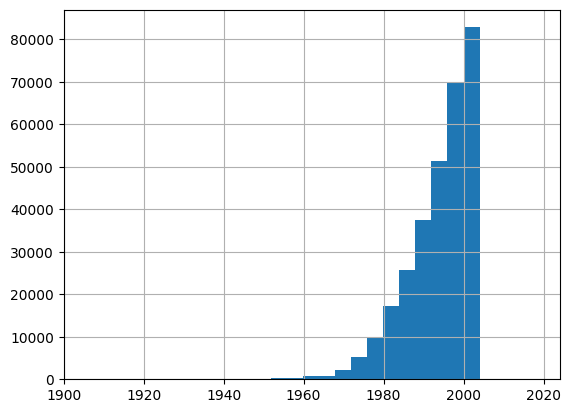

In [82]:
books.loc[books["Year-Of-Publication"] != 0, 'Year-Of-Publication'].hist(bins=100)
plt.xlim(1900, 2024)
plt.show()

Distribusi data tahun rilis buku cenderung left-skewed. Mayoritas buku dirilis setelah tahun 2000. Hal tersebut mengindikasikan bahwa buku yang dirilis terbaru cenderung lebih banyak terjual dibandingkan buku-buku yang diterbitkan beberapa dekade sebelumnya.

###### **Distribusi Age**

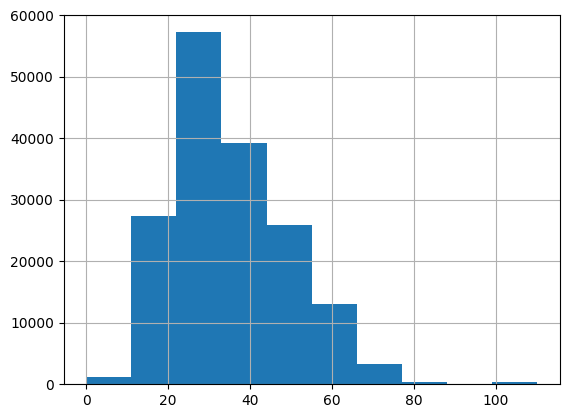

In [83]:
users.loc[users["Age"] != -1, 'Age'].hist()
plt.show()

Usia pembaca mayoritas adalah di rentang 20-30 tahun, menunjukkan minat baca yang lebih tinggi pada usia remaja-dewasa.

###### **Distribusi Ratings**

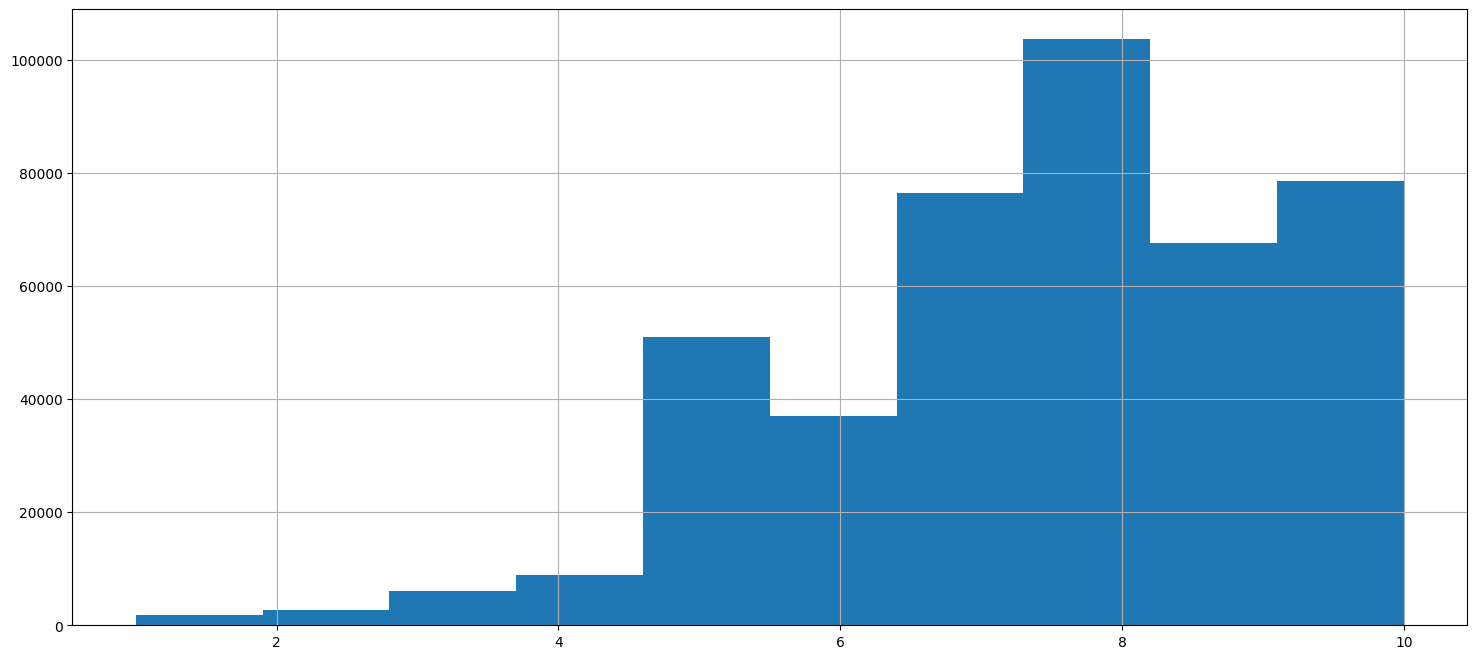

In [84]:
plt.figure(figsize=(18, 8))
ratings.loc[ratings['Book-Rating'] != 0, 'Book-Rating'].hist()
plt.show()

Distribusi pada ratings cenderung left-skewed.

##### **Bivariate**

###### **Author dengan Ratings**

In [85]:
books_ratings = pd.merge(left=books,
                         right=ratings.loc[ratings['Book-Rating'] != 0],
                         on='ISBN',
                         how='inner'
                        )

In [86]:
books_ratings_by_author = books_ratings.groupby('Book-Author').agg({'ISBN': 'count', 'Book-Rating': 'mean'}).sort_values('ISBN', ascending=False)
top20_author = books_ratings_by_author.index.tolist()[:20]
books_ratings_by_author.head(20)

,ISBN,Book-Rating
Book-Author,,
Stephen King,4746,7.798989
John Grisham,3845,7.539922
Nora Roberts,3080,7.667208
Dean Koontz,2125,7.642353
J. K. Rowling,2041,8.873591
James Patterson,1988,7.676559
Patricia Cornwell,1762,7.389330
Anne Rice,1758,7.427190
Michael Crichton,1646,7.509113


Berdasarkan tabel di atas, 20 penulis teratas menurut jumlah ratings memiliki rata-rata ratings di antara 7.1-8.9

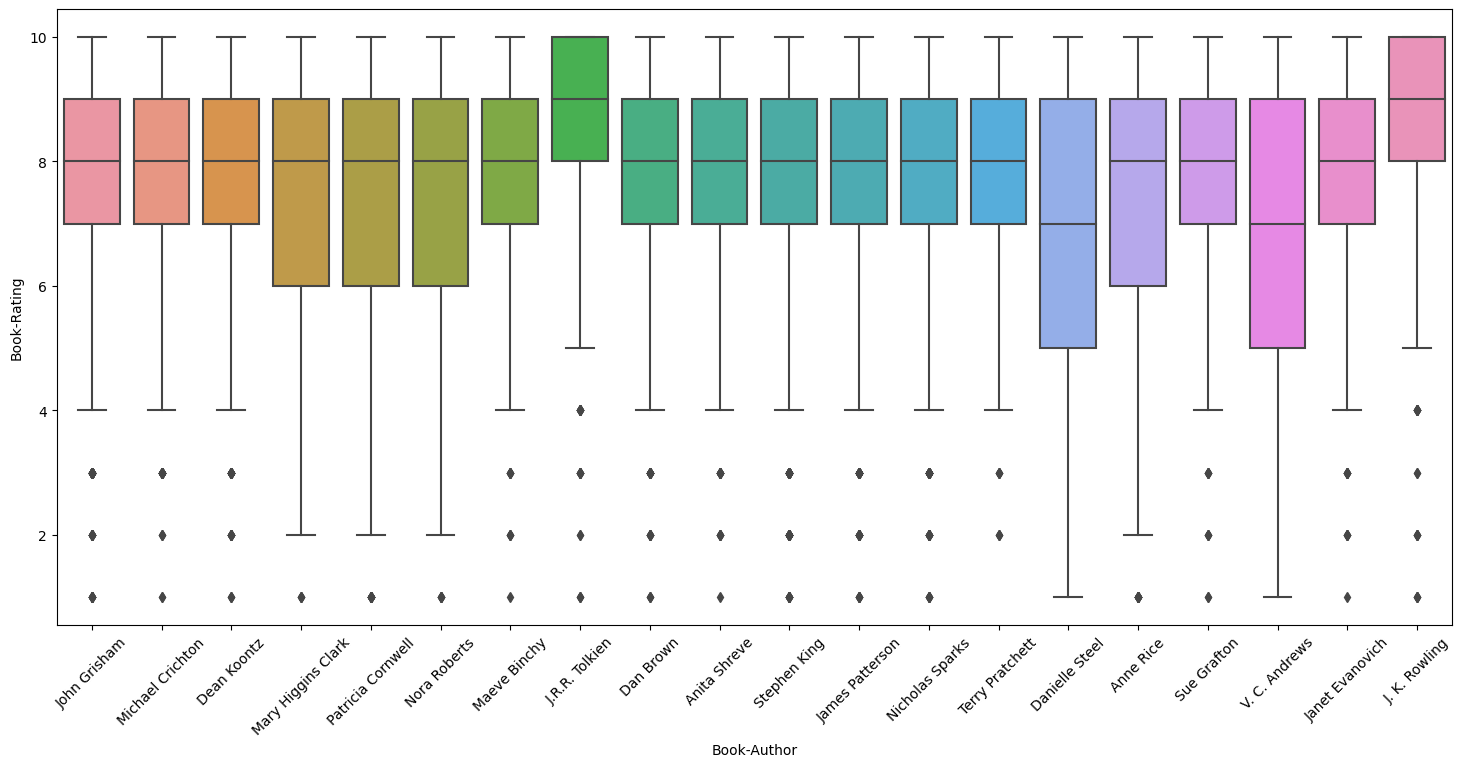

In [87]:
plt.figure(figsize=(18, 8))
sns.boxplot(data=books_ratings.loc[books_ratings['Book-Author'].isin(books_ratings_by_author.head(20).index)],
            y='Book-Rating',
            x='Book-Author'
           )
plt.xticks(rotation=45)
plt.show()

Berdasarkan *boxplot* di atas, dapat disimpulkan bahwa J.R.R. Tolkien dan J.K. Rowling memiliki ratings yang cenderung lebih positif, ditandai dengan median yang lebih tinggi dan sebaran yang lebih sempit. Sedangkan, beberapa penulis seperti Danielle Steel dan V.C. Andrews memiliki median yang lebih rendah serta sebaran yang lebih luas. Visualisasi dari *boxplot* mengindikasikan adanya perbedaan ratings antar penulis.

In [88]:
from scipy.stats import f_oneway

books_ratings_gq_30 = books_ratings['Book-Author'].value_counts().reset_index().loc[lambda x: x['count'] >= 30, 'Book-Author']
groups = [books_ratings.loc[books_ratings['Book-Author'] == author, 'Book-Rating'].values.tolist() \
          for author in books_ratings_gq_30]
k = len(books_ratings_gq_30)
N = sum([len(g) for g in groups])

f, pval = f_oneway(*groups)
eta_squared = (f * (k - 1)) / (f * (k - 1) + (N - k))

print(f"F Statistic = {f:.5f}")
print(f"P-Value = {pval}")
print(f"Effect size = {eta_squared:.5f}")

F Statistic = 10.87781
P-Value = 0.0
Effect size = 0.07713


Uji ANOVA dilakukan untuk mengetahui apakah terdapat perbedaan ratings yang signifikan antara penulis, serta mengetahui ukuran pengaruh dari penulis terhadap variansi dari ratings. Hasil pengujian menunjukkan nilai *p-value* yang sangat kecil, menandakan perbedaan ratings yang signifikan antara penulis-penulis tersebut. *Effect size* yang bernilai 0,077 mengindikasikan bahwa sebanyak 7,7% variansi ratings dapat dijelaskan berdasarkan penulisnya, dan 92,4% lainnya dipengaruhi faktor-faktor lainnya. Dengan demikian, meskipun perbedaan ratings antar penulis signifikan secara statistik, pengaruh penulis terhadap ratings hanya salah satu dari faktor-faktor yang lain.

###### **Publisher dengan Ratings**

In [89]:
books_ratings_by_publisher = books_ratings.groupby('Publisher').agg({'ISBN': 'count', 'Book-Rating': 'mean'}).sort_values('ISBN', ascending=False)
top20_publisher = books_ratings_by_publisher.index.tolist()[:20]
books_ratings_by_publisher.head(20)

,ISBN,Book-Rating
Publisher,,
Ballantine Books,12139,7.666529
Bantam Books,10228,7.712652
Pocket Books,9072,7.546517
Penguin Books,6704,7.731951
Warner Books,6639,7.530200
Dell,5838,7.548818
Signet,5027,7.526358
Berkley Books,4394,7.419663
Vintage Books,4368,7.681548


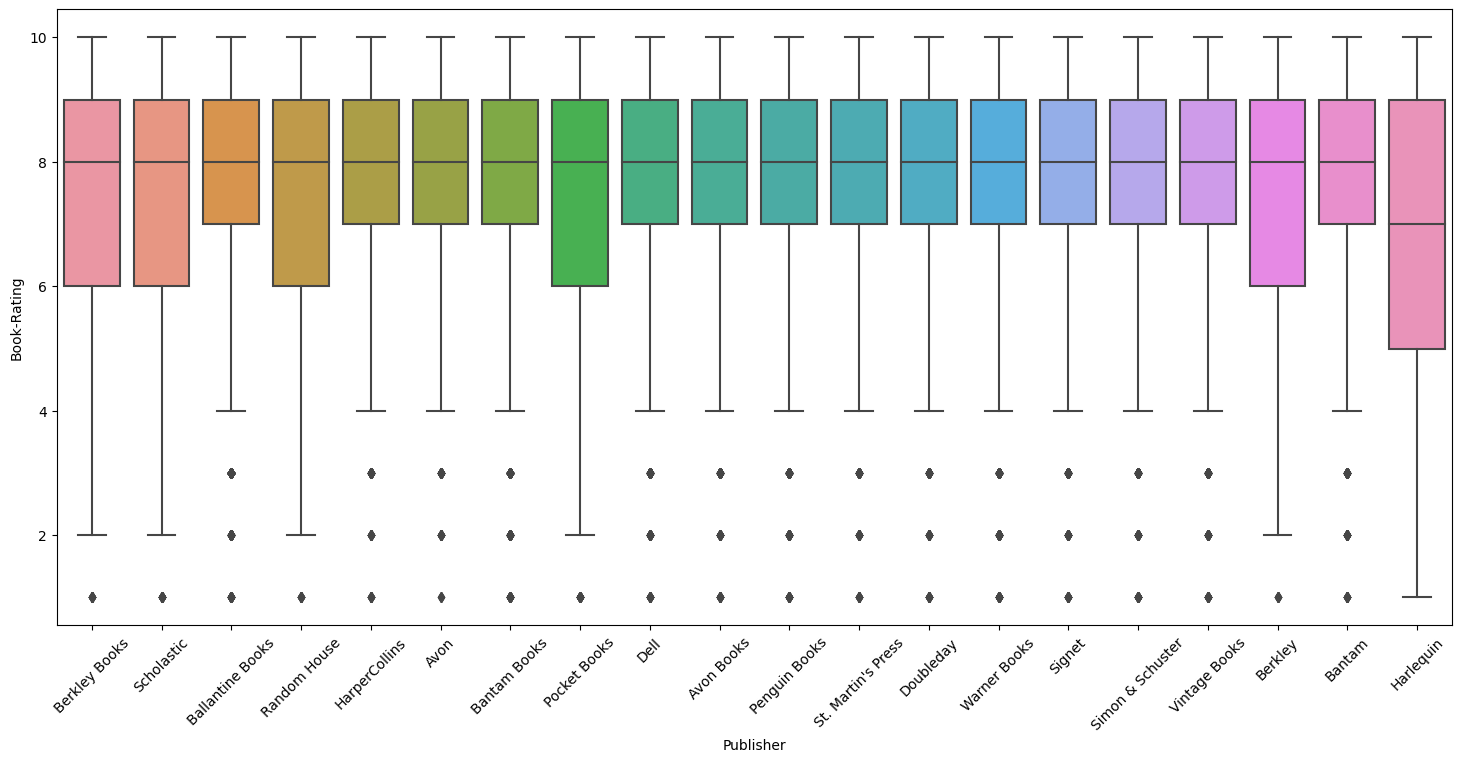

In [90]:
plt.figure(figsize=(18, 8))
sns.boxplot(data=books_ratings.loc[books_ratings['Publisher'].isin(books_ratings_by_publisher.head(20).index)],
            y='Book-Rating',
            x='Publisher'
           )
plt.xticks(rotation=45)
plt.show()

Ratings untuk 20 penerbit yang menerbitkan buku terbanyak menunjukkan median yang setara, kecuali untuk Harlequin. Beberapa penerbit seperti Berkley, Scholastic, Random House, Pocket Books, dan Harlequin memiliki sebaran yang lebih luas.

In [91]:
from scipy.stats import f_oneway

books_ratings_pub_gq_30 = books_ratings['Publisher'].value_counts().reset_index().loc[lambda x: x['count'] >= 30, 'Publisher']
groups = [books_ratings.loc[books_ratings['Publisher'] == pub, 'Book-Rating'].values.tolist() \
          for pub in books_ratings_pub_gq_30]
k = len(books_ratings_pub_gq_30)
N = sum([len(g) for g in groups])

f, pval = f_oneway(*groups)
eta_squared = (f * (k - 1)) / (f * (k - 1) + (N - k))

print(f"F Statistic = {f:.5f}")
print(f"P-Value = {pval}")
print(f"Effect size = {eta_squared:.5f}")

F Statistic = 8.84033
P-Value = 0.0
Effect size = 0.03403


Nilai *effect size* yang lebih kecil mengindikasikan bahwa faktor penulis lebih berpengaruh terhadap ratings daripada publisher.

###### **Country dengan Age**

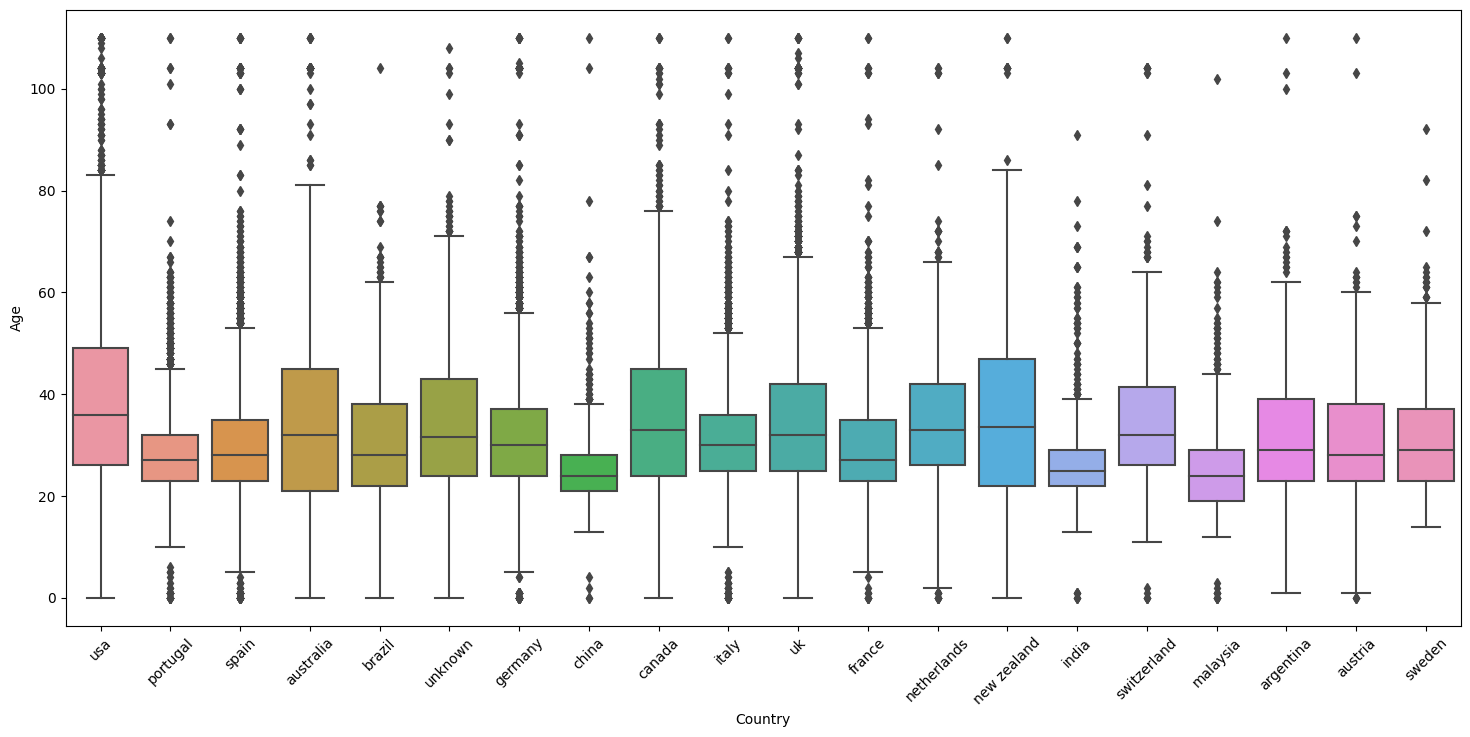

In [92]:
top20_countries = users['Country'].value_counts().reset_index().head(20)['Country'].values

plt.figure(figsize=(18, 8))
sns.boxplot(data=users.loc[(users['Country'].isin(top20_countries)) & (users['Age'] != -1)],
            x='Country',
            y='Age'
           )
plt.xticks(rotation=45)
plt.show()

Berdasarkan *boxplot*, dapat disimpulkan bahwa rentang median usia pada negara dengan jumlah *users* terbanyak adalah 20-35 tahun. Negara-negara Asia seperti China, India, dan Malaysia memiliki median usia yang lebih muda dan persebaran yang lebih sempit berdasarkan interkuartil, mengindikasikan minat baca yang lebih tinggi pada usia muda untuk negara-negara tersebut.

###### **Country dengan Ratings**

In [93]:
users_ratings = pd.merge(left=users, 
                         right=ratings.loc[ratings['Book-Rating'] != 0], 
                         on='User-ID', 
                         how='inner')
users_ratings.head(10)

,User-ID,Location,Age,City,Province,Country,Age Missing,ISBN,Book-Rating
0,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,0002005018,5
1,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,074322678X,5
2,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,0887841740,5
3,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,1552041778,5
4,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,1567407781,6
5,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,1575663937,6
6,8,"timmins, ontario, canada",-1.0,timmins,ontario,canada,True,1881320189,7
7,9,"germantown, tennessee, usa",-1.0,germantown,tennessee,usa,True,0452264464,6
8,10,"albacete, wisconsin, spain",26.0,albacete,wisconsin,spain,False,8477024456,6
9,12,"fort bragg, california, usa",-1.0,fort bragg,california,usa,True,1879384493,10


In [94]:
from scipy.stats import f_oneway

countries_ge_30 = users['Country'].value_counts().reset_index().loc[lambda x: x['count'] >= 30, 'Country']
groups = [users_ratings.loc[users_ratings['Country'] == country, 'Book-Rating'] for country in countries_ge_30]
k = len(countries_ge_30)
N = sum([len(g) for g in groups])

f, pval = f_oneway(*groups)
eta_squared = (f * (k - 1)) / (f * (k - 1) + (N - k))
print(f"F Statistic = {f}")
print(f"P-value = {pval}")
print(f"Effect size = {eta_squared}")

F Statistic = 38.89776191430701
P-value = 0.0
Effect size = 0.007767854078787559


Hasil uji ANOVA menunjukkan terdapat perbedaan ratings antara negara yang signifikan, namun negara asal users hanya menunjukkan *effect size* sebesar 0,7%, menunjukkan pengaruh lokasi terhadap variansi ratings yang rendah.

###### **Age Missing dengan Ratings**

In [95]:
users_ratings.groupby('Age Missing').agg({'Book-Rating': 'mean'})

,Book-Rating
Age Missing,
False,7.706680
True,7.349926


Rata-rata ratings yang diberikan users yang diketahui usianya lebih tinggi daripada users yang usianya tidak diketahui.

In [96]:
from scipy.stats import ttest_ind

groups = [users_ratings.loc[users_ratings['Age Missing'] == status, 'Book-Rating'] for status in users_ratings['Age Missing'].unique()]

t, pval = ttest_ind(*groups)
n1 = len(groups[0])
n2 = len(groups[1])
eta_squared = t**2 / (t**2 + (n1+n2-2))

print(f"t statistic = {t}")
print(f"p-value = {pval}")
print(f"Effect size = {eta_squared}")

t statistic = -58.3973264038694
p-value = 0.0
Effect size = 0.0078024270393320895


Berdasarkan hasil uji t, dapat disimpulkan bahwa status tidak diketahuinya usia hanya menjelaskan 0,7% dari variansi ratings, meskipun terdapat perbedaan rata-rata ratings yang signifikan antara users yang usianya diketahui dan users yang usianya tidak diketahui.

##### **Multivariate : Correlation**

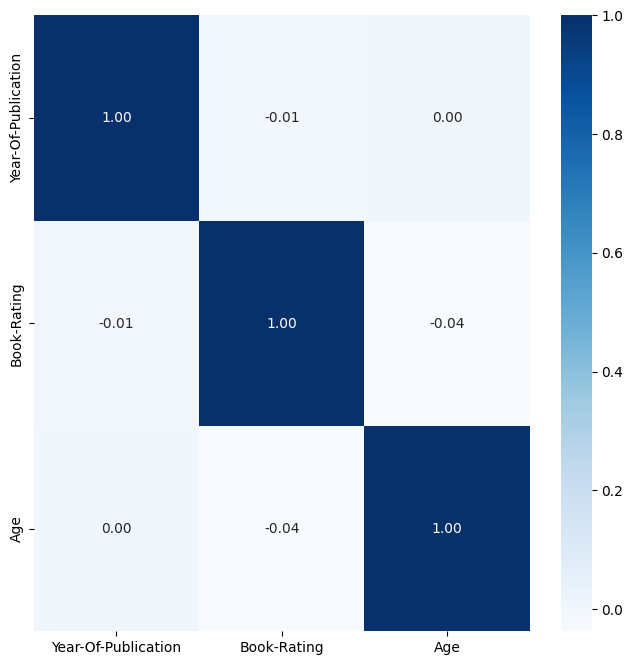

In [97]:
merge_df_eda = pd.merge(left=users, right=ratings, on='User-ID', how='inner')
merge_df_eda = pd.merge(left=merge_df_eda, right=books, on='ISBN', how='inner')
merge_df_eda = merge_df_eda.loc[(merge_df_eda['Year-Of-Publication'] != 0) & (merge_df_eda['Book-Rating'] != 0)\
& merge_df_eda['Age'] != -1, ['Year-Of-Publication', 'Book-Rating', 'Age']]

plt.figure(figsize=(8, 8))
sns.heatmap(merge_df_eda.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

Berdasarkan *heatmap*, dapat disimpulkan bahwa tidak ada fitur numerik yang memiliki korelasi kuat dengan ratings dari buku.

In [31]:
users.to_csv('users_cleaned.csv', index=False)
books.to_csv('books_cleaned.csv', index=False)
ratings.to_csv('ratings_cleaned.csv', index=False)

## **Data Preparation**

In [4]:
users = pd.read_csv('users_cleaned.csv')
books = pd.read_csv('books_cleaned.csv')
ratings = pd.read_csv('ratings_cleaned.csv')

### **Content-Based Filtering**

Pada rekomendasi berbasis konten, kolom yang akan digunakan adalah judul buku, penulis, dan penerbit. Teknik yang diajukan adalah menggabungkan ketiga atribut menjadi satu kalimat. Kalimat-kalimat tersebut kemudian akan ditokenisasi menggunakan TF-IDF Vectorizer. Kemudian, setiap buku dengan setiap vector TF-IDF nya masing-masing akan dihitung kemiripannya satu sama lain dengan cosine similarity.

In [5]:
books_cbrec = books.copy()

In [6]:
books_cbrec = books_cbrec.loc[:, ['Book-Title', 'Book-Author', 'Publisher']]

In [7]:
books_cbrec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308209 entries, 0 to 308208
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Book-Title   308209 non-null  object
 1   Book-Author  308209 non-null  object
 2   Publisher    308209 non-null  object
dtypes: object(3)
memory usage: 7.1+ MB


In [8]:
books_cbrec['Book Attributes'] = books_cbrec['Book-Title']+' '+books_cbrec['Book-Author']+' '+books_cbrec['Publisher']
books_cbrec['Book Attributes'] = books_cbrec['Book Attributes'].apply(lambda x: x.lower())

In [9]:
books_cbrec.head()

,Book-Title,Book-Author,Publisher,Book Attributes
0,Classical mythology,Mark P. O. Morford,Oxford University Press,classical mythology mark p. o. morford oxford ...
1,Clara Callan,Richard Bruce Wright,HarperFlamingoCanada,clara callan richard bruce wright harperflamin...
2,Decision in Normandy,Carlo D'Este,HarperPerennial,decision in normandy carlo d'este harperperennial
3,FLU,Gina Kolata,"Farrar, Straus and Giroux","flu gina kolata farrar, straus and giroux"
4,The mummies of Urumchi,"E. J. W. Barber, Elizabeth Wayland Barber",W.W. Norton & Company,"the mummies of urumchi e. j. w. barber, elizab..."


In [10]:
books_cbrec.drop(columns=['Book-Author', 'Publisher'], inplace=True)

### **Collaborative Filtering**

#### **Merge Dataframe**

Ketiga dataframe akan di-merge dengan metode inner, sehingga data yang terpilih hanya ISBN yang ada pada kedua tabel Rating dan Books, serta User ID pada tabel Users dan Ratings.

In [5]:
merged_data = users.merge(ratings, on='User-ID', how='inner')
merged_data = books.merge(merged_data, on='ISBN', how='inner')

In [6]:
merged_data = merged_data.loc[merged_data['Book-Rating'] != 0]
merged_data_copy = merged_data.copy()

In [7]:
merged_data.drop(columns=['City', 'Province', 'Country'], inplace=True) # Membuang kolom yang tidak diperlukan

In [8]:
merged_data.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Location,Age,Age Missing,Book-Rating
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingoCanada,8,"timmins, ontario, canada",-1.0,True,5
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingoCanada,11676,"unknown, unknown, unknown",-1.0,True,8
5,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingoCanada,67544,"toronto, ontario, canada",30.0,False,8
8,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingoCanada,116866,"ottawa, unknown, unknown",-1.0,True,9
9,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingoCanada,123629,"kingston, ontario, canada",-1.0,True,9


#### **Menambah Fitur Year Missing**

In [9]:
merged_data.insert(3,
                   'Year Missing',
                   merged_data['Year-Of-Publication'].apply(lambda x: np.where(x == 0, 1, 0))
                  )

In [10]:
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Location,Age,Age Missing,Book-Rating
1,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,8,"timmins, ontario, canada",-1.0,True,5
3,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,11676,"unknown, unknown, unknown",-1.0,True,8
5,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,67544,"toronto, ontario, canada",30.0,False,8
8,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,116866,"ottawa, unknown, unknown",-1.0,True,9
9,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,123629,"kingston, ontario, canada",-1.0,True,9


#### **Binning Age**

Age akan dikategorikan berdasarkan rentang tertentu. Pada project ini, rentang usia yang digunakan bersumber dari *website* [Kemenkes RI](https://ayosehat.kemkes.go.id/kategori-usia), dengan rincian sebagai berikut.

- 0 - 4 tahun   : Bayi dan Balita (0)
- 5 - 9 tahun   : Anak-anak (1)
- 10 - 18 tahun : Remaja (2)
- 19 - 59 tahun : Dewasa (3)
- 60 -          : Lansia (4)

In [11]:
merged_data.insert(7, 
                   'Age-Group',
                   pd.cut(merged_data['Age'], 
                          bins=[-1, 0, 5, 10, 19, 60, max(merged_data['Age'])+1],
                          labels=list(range(-1, 5)),
                          include_lowest=True,
                          right=False
                         )
                  )

In [12]:
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,8,-1,"timmins, ontario, canada",-1.0,True,5
3,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,11676,-1,"unknown, unknown, unknown",-1.0,True,8
5,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,67544,3,"toronto, ontario, canada",30.0,False,8
8,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,116866,-1,"ottawa, unknown, unknown",-1.0,True,9
9,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,123629,-1,"kingston, ontario, canada",-1.0,True,9


#### **Normalisasi Fitur Age**

In [13]:
age_scaler = MinMaxScaler()

merged_data.loc[merged_data['Age'] != -1, 'Age'] = \
age_scaler.fit_transform(np.reshape(merged_data.loc[merged_data['Age'] != -1, 'Age'].values, (-1, 1)))
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,8,-1,"timmins, ontario, canada",-1.000000,True,5
3,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,11676,-1,"unknown, unknown, unknown",-1.000000,True,8
5,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,67544,3,"toronto, ontario, canada",0.272727,False,8
8,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,116866,-1,"ottawa, unknown, unknown",-1.000000,True,9
9,0002005018,Clara Callan,Richard Bruce Wright,0,2001,HarperFlamingoCanada,123629,-1,"kingston, ontario, canada",-1.000000,True,9


#### **Normalisasi Fitur Year of Publication**

In [14]:
year_scaler = MinMaxScaler()

merged_data['Year-Of-Publication'] = merged_data['Year-Of-Publication'].astype(np.float64)
merged_data.loc[merged_data['Year-Of-Publication'] != 0, 'Year-Of-Publication'] = \
year_scaler.fit_transform(np.reshape(merged_data.loc[merged_data['Year-Of-Publication'] != 0, 'Year-Of-Publication'].values, (-1, 1)))

merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,8,-1,"timmins, ontario, canada",-1.000000,True,5
3,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,11676,-1,"unknown, unknown, unknown",-1.000000,True,8
5,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,67544,3,"toronto, ontario, canada",0.272727,False,8
8,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,116866,-1,"ottawa, unknown, unknown",-1.000000,True,9
9,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,123629,-1,"kingston, ontario, canada",-1.000000,True,9


#### **Normalisasi Fitur Book-Rating**

In [15]:
ratings_scaler = MinMaxScaler()

merged_data['Book-Rating'] = merged_data['Book-Rating'].astype(np.float64)
merged_data.loc[merged_data['Book-Rating'] != 0, 'Book-Rating'] = ratings_scaler.fit_transform(
    np.reshape(merged_data.loc[merged_data['Book-Rating'] != 0, 'Book-Rating'].values, (-1, 1))
)
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,8,-1,"timmins, ontario, canada",-1.000000,True,0.444444
3,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,11676,-1,"unknown, unknown, unknown",-1.000000,True,0.777778
5,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,67544,3,"toronto, ontario, canada",0.272727,False,0.777778
8,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,116866,-1,"ottawa, unknown, unknown",-1.000000,True,0.888889
9,0002005018,Clara Callan,Richard Bruce Wright,0,0.992537,HarperFlamingoCanada,123629,-1,"kingston, ontario, canada",-1.000000,True,0.888889


#### **Lowercase Text**

In [16]:
merged_data[['Book-Title', 'Book-Author', 'Location']] = \
merged_data[['Book-Title', 'Book-Author', 'Location']].map(lambda x: x.lower())

merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,clara callan,richard bruce wright,0,0.992537,HarperFlamingoCanada,8,-1,"timmins, ontario, canada",-1.000000,True,0.444444
3,0002005018,clara callan,richard bruce wright,0,0.992537,HarperFlamingoCanada,11676,-1,"unknown, unknown, unknown",-1.000000,True,0.777778
5,0002005018,clara callan,richard bruce wright,0,0.992537,HarperFlamingoCanada,67544,3,"toronto, ontario, canada",0.272727,False,0.777778
8,0002005018,clara callan,richard bruce wright,0,0.992537,HarperFlamingoCanada,116866,-1,"ottawa, unknown, unknown",-1.000000,True,0.888889
9,0002005018,clara callan,richard bruce wright,0,0.992537,HarperFlamingoCanada,123629,-1,"kingston, ontario, canada",-1.000000,True,0.888889


#### **Mengubah Data Kategorikal menjadi Numerikal**

##### **Publisher**

In [17]:
pub_to_num = {name: num for num, name in enumerate(merged_data['Publisher'].unique())}
num_to_pub = {num: name for name, num in pub_to_num.items()}

merged_data['Publisher'] = merged_data['Publisher'].map(pub_to_num)
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,clara callan,richard bruce wright,0,0.992537,0,8,-1,"timmins, ontario, canada",-1.000000,True,0.444444
3,0002005018,clara callan,richard bruce wright,0,0.992537,0,11676,-1,"unknown, unknown, unknown",-1.000000,True,0.777778
5,0002005018,clara callan,richard bruce wright,0,0.992537,0,67544,3,"toronto, ontario, canada",0.272727,False,0.777778
8,0002005018,clara callan,richard bruce wright,0,0.992537,0,116866,-1,"ottawa, unknown, unknown",-1.000000,True,0.888889
9,0002005018,clara callan,richard bruce wright,0,0.992537,0,123629,-1,"kingston, ontario, canada",-1.000000,True,0.888889


##### **Author**

In [18]:
author_tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
author_tokenizer.fit_on_texts(merged_data['Book-Author'])
author_tokenizer.index_word[0] = ''

In [19]:
def text_to_seq(tokenizer, text, maxlen=10) :
  sequence = tokenizer.texts_to_sequences([text])[0]
  padded = pad_sequences([sequence], maxlen=maxlen, padding='post')
  return padded[0]

In [20]:
merged_data['Book-Author'] = merged_data['Book-Author'].apply(lambda x: text_to_seq(author_tokenizer, x))
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,8,-1,"timmins, ontario, canada",-1.000000,True,0.444444
3,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,11676,-1,"unknown, unknown, unknown",-1.000000,True,0.777778
5,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,67544,3,"toronto, ontario, canada",0.272727,False,0.777778
8,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,116866,-1,"ottawa, unknown, unknown",-1.000000,True,0.888889
9,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,123629,-1,"kingston, ontario, canada",-1.000000,True,0.888889


##### **Lokasi**

In [21]:
loc_tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
loc_tokenizer.fit_on_texts(merged_data['Location'])
loc_tokenizer.index_word[0] = ''

In [22]:
merged_data['Location'] = merged_data['Location'].apply(lambda x: text_to_seq(loc_tokenizer, x))
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,8,-1,"[3455, 8, 4, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.444444
3,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,11676,-1,"[3, 3, 3, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.777778
5,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,67544,3,"[33, 8, 4, 0, 0, 0, 0, 0, 0, 0]",0.272727,False,0.777778
8,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,116866,-1,"[58, 3, 3, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.888889
9,0002005018,clara callan,"[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,123629,-1,"[356, 8, 4, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.888889


##### **Book Title**

In [23]:
book_tokenizer = Tokenizer(num_words=100000, oov_token='<OOV>')
book_tokenizer.fit_on_texts(merged_data['Book-Title'])
book_tokenizer.index_word[0] = ''

In [24]:
merged_data['Book-Title'] = merged_data['Book-Title'].apply(lambda x: text_to_seq(book_tokenizer, x, maxlen=50))
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,8,-1,"[3455, 8, 4, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.444444
3,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,11676,-1,"[3, 3, 3, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.777778
5,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,67544,3,"[33, 8, 4, 0, 0, 0, 0, 0, 0, 0]",0.272727,False,0.777778
8,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,116866,-1,"[58, 3, 3, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.888889
9,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,123629,-1,"[356, 8, 4, 0, 0, 0, 0, 0, 0, 0]",-1.000000,True,0.888889


##### **Tipe Data Age Missing**

In [25]:
merged_data['Age Missing'] = merged_data['Age Missing'].astype(np.int64)
merged_data.head()

,ISBN,Book-Title,Book-Author,Year Missing,Year-Of-Publication,Publisher,User-ID,Age-Group,Location,Age,Age Missing,Book-Rating
1,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,8,-1,"[3455, 8, 4, 0, 0, 0, 0, 0, 0, 0]",-1.000000,1,0.444444
3,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,11676,-1,"[3, 3, 3, 0, 0, 0, 0, 0, 0, 0]",-1.000000,1,0.777778
5,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,67544,3,"[33, 8, 4, 0, 0, 0, 0, 0, 0, 0]",0.272727,0,0.777778
8,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,116866,-1,"[58, 3, 3, 0, 0, 0, 0, 0, 0, 0]",-1.000000,1,0.888889
9,0002005018,"[4644, 7363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[17, 208, 444, 0, 0, 0, 0, 0, 0, 0]",0,0.992537,0,123629,-1,"[356, 8, 4, 0, 0, 0, 0, 0, 0, 0]",-1.000000,1,0.888889


#### **Pisah Data User, Buku, dan Rating**

In [26]:
merged_data.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year Missing',
       'Year-Of-Publication', 'Publisher', 'User-ID', 'Age-Group', 'Location',
       'Age', 'Age Missing', 'Book-Rating'],
      dtype='object')

In [27]:
book_titles = tf.data.Dataset.from_tensor_slices(
    np.array(merged_data['Book-Title'].apply(lambda x: list(x)).values.tolist())
)
book_authors = tf.data.Dataset.from_tensor_slices(
    np.array(merged_data['Book-Author'].apply(lambda x: list(x)).values.tolist())
)
book_years = tf.data.Dataset.from_tensor_slices(
    merged_data[['Year-Of-Publication', 'Year Missing']].values
)
book_publishers = tf.data.Dataset.from_tensor_slices(merged_data['Publisher'].values)

locs = tf.data.Dataset.from_tensor_slices(
    np.array(merged_data['Location'].apply(lambda x: list(x)).values.tolist())
)
ages = tf.data.Dataset.from_tensor_slices(merged_data[['Age', 'Age-Group', 'Age Missing']])

book_ratings = tf.data.Dataset.from_tensor_slices(merged_data['Book-Rating'].values)

In [28]:
data_tf = tf.data.Dataset.zip(
    tf.data.Dataset.zip(
        book_titles,
        book_authors,
        book_years,
        book_publishers,
        locs,
        ages
    ),
    book_ratings
)

#### **Split Training dan Testing**

In [29]:
training_size = int(0.8*len(merged_data))
val_size = int(0.1*len(merged_data))

train_data = data_tf.take(training_size)
train_data = train_data.cache().shuffle(32).batch(32).prefetch(tf.data.AUTOTUNE)

val_data = data_tf.skip(training_size).take(val_size)
val_data = val_data.cache().batch(32).prefetch(tf.data.AUTOTUNE)

test_data = data_tf.skip(training_size+val_size)
test_data = test_data.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## **Modelling**

### **Content-Based (Cosine Similarity)**

Pada laporan ini, kemiripan konten dihitung dengan cosine similarity. Sebelumnya, data tekstual telah ditokenisasi menggunakan TF-IDF Vectorizer, yang melakukan tokenisasi berdasarkan frekuensi kemunculan setiap kata pada tiap atribut buku.

Rumus dari TF (Term Frequency) adalah sebagai berikut.

$$TF(X, d) = \frac{\text{Jumlah Kemunculan kata X}}{\text{Total jumlah kata X pada dokumen d}}$$

Sedangkan, untuk IDF (Inverse Document Frequency) dapat dirumuskan sebagai berikut.

$$IDF(X,d) = log\frac{\text{Total jumlah teks pada dokumen}}{\text{Jumlah dokumen yang mengandung kata X}}$$

Data setelah dilakukan tokenisasi akan berdimensi (jumlah data x jumlah kata unik). Kemudian, kemiripan antar konten dapat dihitung dengan cosine similarity dengan rumus sebagai berikut.

$$Cos\text{ }\theta = \frac{a.b}{||a||.||b||}$$

a.b adalah dot product antara kedua vektor. Sementara itu, ||a|| dan ||b|| berturut-turut adalah panjang vektor a dan b. Nilai cosine similarity memiliki rentang 0 hingga 1, dimana 1 menandakan kemiripan yang tinggi.

Kelebihan dari content-based filtering adalah rekomendasi tidak tergantung pada data pengguna. Algoritma ini juga lebih transparan karena rekomendasi diberikan berdasarkan kemiripan konten yang lebih terlihat jelas.

Kekurangan dari algoritma ini adalah rekomendasi terbatas pada konten yang mirip, tidak menyediakan konten baru yang mungkin juga disukai oleh pengguna berdasarkan demografi mereka.

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(books_cbrec['Book Attributes'])

In [37]:
tfidf.get_feature_names_out().shape

(121762,)

In [38]:
tfidf_matrix = tfidf.transform(books_cbrec['Book Attributes'])

In [39]:
tfidf_matrix.shape

(308209, 121762)

#### **Hasil Rekomendasi**

In [40]:
def get_recommendation(idx) :
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix)[0]
    recommendations_idx = np.argsort(-cosine_sim)[1:11]
    
    print("BOOK CHOICE :")
    print(f"Title\t\t: {books.iloc[idx]['Book-Title']}")
    print(f"Author\t\t: {books.iloc[idx]['Book-Author']}")
    print(f"Publisher\t: {books.iloc[idx]['Publisher']}")
    print("-"*18)
    print("Books Recommendation\n")
    for n, i in enumerate(recommendations_idx) :
        print(f"{n+1}.\tTitle\t\t:{books.iloc[i]['Book-Title']}")
        print(f"\tAuthor\t\t:{books.iloc[i]['Book-Author']}")
        print(f"\tPublisher\t:{books.iloc[i]['Publisher']}")
        print()

In [41]:
book_choice = np.random.choice(np.arange(0, len(books)))
get_recommendation(book_choice)

BOOK CHOICE :
Title		: Stranger's caress.
Author		: Susan Sackett
Publisher	: Zebra
------------------
Books Recommendation

1.	Title		:Reckless
	Author		:Susan Sackett
	Publisher	:Zebra

2.	Title		:Seaswept (Lovegram)
	Author		:Susan Sackett
	Publisher	:Zebra

3.	Title		:California Caress
	Author		:Rebecca Sinclair
	Publisher	:Zebra

4.	Title		:A taste of passion.
	Author		:Susan Sackett
	Publisher	:Kensington Publishing

5.	Title		:Seductive Caress
	Author		:C. Simpson
	Publisher	:Zebra

6.	Title		:Letters to Star trek
	Author		:Susan Sackett
	Publisher	:Ballantine Books

7.	Title		:Counterfeit Caress
	Author		:Elizabeth Leigh
	Publisher	:Zebra

8.	Title		:Rebel's Tender Caress (Zebra Books)
	Author		:Jane Toombs
	Publisher	:Zebra

9.	Title		:Arizona caress
	Author		:Bobbi Smith
	Publisher	:Zebra Books

10.	Title		:Creole Caress
	Author		:Elizabeth Leigh
	Publisher	:Zebra



### **Collaborative Filtering**

Model yang digunakan pada laporan ini adalah Deep Learning dengan layer Embeddings yang berbeda untuk data buku dan data user dan attention mechanism. Layer Embeddings akan merepresentasikan data dalam ruang multidimensi. Representasi tersebut menggambarkan makna semantik dari setiap kata/atribut. Kemiripan antar data dapat diukur berdasarkan embeddings. Kemiripan inilah yang menerapkan algoritma collaborative filtering, dimana rekomendasi diberikan dengan tidak hanya mempertimbangkan konten, namun juga demografi/karakteristik pengguna yang mirip.

Kelebihan dari algoritma collaborative filtering adalah mampu memberikan rekomendasi yang bervariasi dan lebih luas cakupannya, karena tidak hanya merekomendasikan item serupa, namun juga item yang mungkin disukai pengguna berdasarkan data pengguna lain dengan demografi yang mirip.

Kelemahan dari algoritma ini adalah memerlukan data demografi dari pengguna, sehingga untuk rekomendasi bagi pengguna dengan data yang kurang lengkap akan lebih sulit ditentukan.

In [30]:
class SingleHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d, **kwargs):
        super().__init__(**kwargs)
        self.d = d
    def build(self, input_shape):
        self.qweights = self.add_weight(
            name='Wq',
            shape=(input_shape[-1], self.d),
            initializer='random_normal',
            dtype=tf.float32,
            trainable=True
        )
        self.kweights = self.add_weight(
            name='Wk',
            shape=(input_shape[-1], self.d),
            initializer='random_normal',
            dtype=tf.float32,
            trainable=True
        )
        self.vweights = self.add_weight(
            name='Wv',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='random_normal',
            dtype=tf.float32,
            trainable=True
        )
        super().build(input_shape)
    def call(self, inputs):
        Q = tf.matmul(inputs, self.qweights)
        K = tf.matmul(inputs, self.kweights)
        QK = tf.nn.softmax(
            tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(self.d, tf.float32)),
            axis=-1
        )
        V = tf.matmul(inputs, self.vweights)
        outputs = inputs + tf.matmul(QK, V)
        return outputs
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        config = super().get_config()
        config.update({
            'd': self.d
        })
        return config

In [44]:
with strategy.scope():
    titles_input = tf.keras.Input(shape=(50, ))
    authors_input = tf.keras.Input(shape=(10, ))
    years_input = tf.keras.Input(shape=(2, ))
    publishers_input = tf.keras.Input(shape=(1, ))
    
    locs_input = tf.keras.Input(shape=(10, ))
    ages_input = tf.keras.Input(shape=(3, ))
    
    titles_pos = tf.expand_dims(tf.range(0, limit=50, delta=1), 0)
    authors_pos = tf.expand_dims(tf.range(0, limit=10, delta=1), 0)
    locs_pos = tf.expand_dims(tf.range(0, limit=10, delta=1), 0)
    
    titles_pos = tf.keras.layers.Embedding(100000, 64, name='titles_pos')(titles_pos)
    authors_pos = tf.keras.layers.Embedding(100000, 64, name='authors_pos')(authors_pos)
    locs_pos = tf.keras.layers.Embedding(100000, 64, name='locs_pos')(locs_pos)
    
    titles_emb = tf.keras.layers.Embedding(100000, 64, name='titles_embedding')(titles_input)
    authors_emb = tf.keras.layers.Embedding(100000, 64, name='authors_embedding')(authors_input)
    locs_emb = tf.keras.layers.Embedding(100000, 64, name='locs_embedding')(locs_input)
    
    titles_rep = tf.keras.layers.Add()([titles_emb, titles_pos])
    authors_rep = tf.keras.layers.Add()([authors_emb, authors_pos])
    locs_rep = tf.keras.layers.Add()([locs_emb, locs_pos])
    
    titles_att = SingleHeadAttention(d=64, name='titles_attention')(titles_rep)
    titles_pool = tf.keras.layers.GlobalAveragePooling1D()(titles_att)
    authors_att = SingleHeadAttention(d=64, name='authors_attention')(authors_rep)
    authors_pool = tf.keras.layers.GlobalAveragePooling1D()(authors_att)
    locs_att = SingleHeadAttention(d=64, name='locs_attention')(locs_rep)
    locs_pool = tf.keras.layers.GlobalAveragePooling1D()(locs_att)
    
    concat_books_pools = tf.keras.layers.Concatenate()([titles_pool, authors_pool])
    books_pools_dense = tf.keras.layers.Dense(32, activation='relu')(concat_books_pools)
    years_dense = tf.keras.layers.Dense(16, activation='relu')(years_input)
    publishers_dense = tf.keras.layers.Dense(16, activation='relu')(publishers_input)
    books_concat = tf.keras.layers.Concatenate()([books_pools_dense, years_dense, publishers_dense])
    
    ages_dense = tf.keras.layers.Dense(16, activation='relu')(ages_input)
    users_concat = tf.keras.layers.Concatenate()([locs_pool, ages_dense])
    
    concat = tf.keras.layers.Concatenate()([books_concat, users_concat])
    rating_pred = tf.keras.layers.Dense(1, activation='sigmoid', name='rating')(concat)
    
    model = tf.keras.Model(inputs=[titles_input, authors_input, years_input, publishers_input, locs_input, ages_input],
                           outputs=rating_pred,
                           name='recommender'
                          )
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss=tf.keras.losses.MeanAbsoluteError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]
                 )

I0000 00:00:1762735467.753578      12 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [45]:
model.summary()

Model: "recommender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ titles_embedding    │ (None, 50, 64)    │  6,400,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ authors_embedding   │ (None, 10, 64)    │  6,400,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 50, 64)       │          0 │ titles_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 10, 64)       │          0 │ authors_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ titles_attention    │ (1, 50, 64)       │     12,288 │ add[0][0]         │
│ (SingleHeadAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ authors_attention   │ (1, 10, 64)       │     12,288 │ add_1[0][0]       │
│ (SingleHeadAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locs_embedding      │ (None, 10, 64)    │  6,400,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (1, 64)           │          0 │ titles_attention… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (1, 64)           │          0 │ authors_attentio… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 10, 64)       │          0 │ locs_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (1, 128)          │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locs_attention      │ (1, 10, 64)       │     12,288 │ add_2[0][0]       │
│ (SingleHeadAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 3)         │          0 │ -               

 Total params: 19,241,281 (73.40 MB)

 Trainable params: 19,241,281 (73.40 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
hist = model.fit(train_data, epochs=25, validation_data=val_data)

Epoch 1/25


I0000 00:00:1762735479.872741      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:7666530615686862851
I0000 00:00:1762735480.452740    1154 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2855528076880359364), session_name()
I0000 00:00:1762735486.290841    1154 tpu_compile_op_common.cc:245] Compilation of 2855528076880359364 with session name  took 5.838048578s and succeeded
I0000 00:00:1762735486.298312    1154 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2855528076880359364), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_7666530615686862851", property.function_library_fingerprint = 17066106402789348258, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

10405/10406 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2658 - root_mean_squared_error: 0.3452

I0000 00:00:1762735751.877618    1150 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14025608608536468623), session_name()
I0000 00:00:1762735757.695600    1150 tpu_compile_op_common.cc:245] Compilation of 14025608608536468623 with session name  took 5.817942539s and succeeded
I0000 00:00:1762735757.702538    1150 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14025608608536468623), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_7666530615686862851", property.function_library_fingerprint = 17066106402789348258, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,50,;3,10,;3,2,;3,;3,10,;3,3,;3,;", property.guaranteed_constants_siz

10406/10406 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2658 - root_mean_squared_error: 0.3451

I0000 00:00:1762735761.341222      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2012283381135834106
I0000 00:00:1762735763.165543    1131 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5209842284240081772), session_name()
I0000 00:00:1762735763.527489    1131 tpu_compile_op_common.cc:245] Compilation of 5209842284240081772 with session name  took 361.90801ms and succeeded
I0000 00:00:1762735763.529831    1131 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5209842284240081772), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2012283381135834106", property.function_library_fingerprint = 14570222882055256340, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

10406/10406 ━━━━━━━━━━━━━━━━━━━━ 315s 29ms/step - loss: 0.2658 - root_mean_squared_error: 0.3451 - val_loss: 0.1837 - val_root_mean_squared_error: 0.2317
Epoch 2/25
10406/10406 ━━━━━━━━━━━━━━━━━━━━ 305s 29ms/step - loss: 0.1666 - root_mean_squared_error: 0.2185 - val_loss: 0.2358 - val_root_mean_squared_error: 0.3063
Epoch 3/25
10406/10406 ━━━━━━━━━━━━━━━━━━━━ 306s 29ms/step - loss: 0.1577 - root_mean_squared_error: 0.2084 - val_loss: 0.2268 - val_root_mean_squared_error: 0.2972
Epoch 4/25
10406/10406 ━━━━━━━━━━━━━━━━━━━━ 307s 29ms/step - loss: 0.1531 - root_mean_squared_error: 0.2048 - val_loss: 0.2393 - val_root_mean_squared_error: 0.3100
Epoch 5/25
10406/10406 ━━━━━━━━━━━━━━━━━━━━ 307s 29ms/step - loss: 0.1472 - root_mean_squared_error: 0.1964 - val_loss: 0.2413 - val_root_mean_squared_error: 0.3116
Epoch 6/25
10406/10406 ━━━━━━━━━━━━━━━━━━━━ 308s 30ms/step - loss: 0.1455 - root_mean_squared_error: 0.1969 - val_loss: 0.2204 - val_root_mean_squared_error: 0.2872
Epoch 7/25
10406/1040

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10406/10406 ━━━━━━━━━━━━━━━━━━━━ 314s 30ms/step - loss: 0.1164 - root_mean_squared_error: 0.1670 - val_loss: 0.1791 - val_root_mean_squared_error: 0.2303
Epoch 24/25
 5995/10406 ━━━━━━━━━━━━━━━━━━━━ 1:59 27ms/step - loss: 0.1198 - root_mean_squared_error: 0.1690

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10406/10406 ━━━━━━━━━━━━━━━━━━━━ 316s 30ms/step - loss: 0.1161 - root_mean_squared_error: 0.1656 - val_loss: 0.1807 - val_root_mean_squared_error: 0.2320
Epoch 25/25
 8471/10406 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - loss: 0.1179 - root_mean_squared_error: 0.1689

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



10406/10406 ━━━━━━━━━━━━━━━━━━━━ 319s 31ms/step - loss: 0.1160 - root_mean_squared_error: 0.1670 - val_loss: 0.1827 - val_root_mean_squared_error: 0.2338


In [47]:
model.save('recommender.keras')

#### **Hasil Rekomendasi**

In [31]:
model = tf.keras.models.load_model('recommender.keras', custom_objects={'SingleHeadAttention': SingleHeadAttention})

In [32]:
users_features_model = tf.keras.Model(
    inputs=[model.get_layer('input_layer_4').output, model.get_layer('input_layer_5').output],
    outputs=model.get_layer('concatenate_2').output
)

users_features_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locs_embedding      │ (None, 10, 64)    │  6,400,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 10, 64)       │          0 │ locs_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locs_attention      │ (1, 10, 64)       │     12,288 │ add_2[0][0]       │
│ (SingleHeadAttenti… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (1, 64)           │          0 │ locs_attention[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │         64 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (1, 80)           │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,412,352 (24.46 MB)

 Trainable params: 6,412,352 (24.46 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
users_data = merged_data[['User-ID', 'Location', 'Age', 'Age-Group', 'Age Missing']].drop_duplicates(subset=['User-ID'])

users_features = users_features_model((np.array(users_data['Location'].apply(lambda x: list(x)).values.tolist()), 
                                      users_data[['Age', 'Age-Group', 'Age Missing']].values
                                      ))
users_dataset = datasets.Dataset.from_dict({
    'user_id': users_data['User-ID'].values.tolist(),
    'embeddings': np.array(users_features)
})

users_dataset.add_faiss_index(column='embeddings')

  0%|          | 0/74 [00:00<?, ?it/s]

Dataset({
    features: ['user_id', 'embeddings'],
    num_rows: 73652
})

In [34]:
id_embeddings_dict = dict(zip(users_dataset['user_id'], users_dataset['embeddings']))

In [81]:
def get_candidates(user_id):
    selected_embedding = np.array(id_embeddings_dict[user_id])
    scores, top_n = users_dataset.get_nearest_examples(
        'embeddings', selected_embedding, k=21
    )
    top_users_id = [uid for uid in top_n['user_id'] if uid != user_id]
    print(f"Top 20 Similar User IDs with User ID {user_id} : \n{top_users_id}")
    print('-'*28)
    return merged_data_copy.loc[merged_data_copy['Book-Title'].isin(
        merged_data_copy.loc[merged_data_copy['User-ID'].isin(top_users_id), 'Book-Title']
    )].drop_duplicates(subset=['Book-Title', 'Book-Author'])

In [64]:
def get_colab_recommendation(user_id) :
    user_location = users.loc[users['User-ID'] == user_id, 'Location'].values[0].lower() # Ambil lokasi user
    user_location = np.expand_dims(text_to_seq(loc_tokenizer, user_location), axis=0)
    user_age = users.loc[users['User-ID'] == user_id, ['Age']]
    user_age['Age-Group'] = pd.cut(user_age['Age'],
                                   bins=[-1, 0, 5, 10, 19, 60, max(users['Age'])+1],
                                   labels=list(range(-1, 5)),
                                   include_lowest=True,
                                   right=False
                                  )
    user_age['Age Missing'] = user_age['Age'].apply(lambda x: np.where(x == -1, 1, 0))
    user_age['Age'] = age_scaler.transform([user_age['Age'].values.tolist()])[0][0]
    user_ages = user_age.values
    
    books_unreaded = get_candidates(user_id)
    books_readed = merged_data_copy[merged_data_copy['User-ID'] == user_id][['Book-Title', 'Book-Author', 'Publisher', 'Book-Rating']].sort_values('Book-Rating', ascending=False)
    books_unreaded = books_unreaded[~books_unreaded['Book-Title'].isin(books_readed['Book-Title'])]

    # Terjemahkan judul, penulis, dan publisher ke angka
    books_unreaded['Book-Title'] = books_unreaded['Book-Title'].apply(lambda x: list(text_to_seq(book_tokenizer, x.lower(), maxlen=50)))
    books_unreaded['Book-Author'] = books_unreaded['Book-Author'].apply(lambda x: list(text_to_seq(author_tokenizer, x.lower())))
    books_unreaded['Year-Of-Publication'] = books_unreaded['Year-Of-Publication'].astype(np.float64)
    books_unreaded.loc[books_unreaded['Year-Of-Publication'] != 0, 'Year-Of-Publication'] = \
    year_scaler.transform(np.reshape(books_unreaded.loc[books_unreaded['Year-Of-Publication'] != 0, 'Year-Of-Publication'].values, (-1, 1)))
    books_unreaded['Year Missing'] = books_unreaded['Year-Of-Publication'].apply(lambda x: np.where(x == 0, 1, 0))
    
    books_unreaded['Publisher'] = books_unreaded['Publisher'].apply(lambda x: pub_to_num[x])
    user_location = np.repeat(user_location, len(books_unreaded), axis=0) # Repeat sesuai jml. buku yang belum dibaca
    user_ages = np.repeat(user_ages, len(books_unreaded), axis=0)

    recommendations = model.predict((np.array(books_unreaded['Book-Title'].values.tolist()),
                                    np.array(books_unreaded['Book-Author'].values.tolist()),
                                    books_unreaded[['Year-Of-Publication', 'Year Missing']].values,
                                    books_unreaded['Publisher'].values,
                                    user_location,
                                    user_ages),
                                    verbose=0
                                   ).flatten()
    
    books_unreaded['Predicted Rating'] = recommendations
    books_unreaded = books_unreaded.sort_values('Predicted Rating', ascending=False).head(10)

    #Terjemahkan angka ke nama penulis, penerbit, dan judul buku
    books_unreaded['Book-Author'] = books_unreaded['Book-Author'].apply(lambda x: author_tokenizer.sequences_to_texts([x])[0].title())
    books_unreaded['Publisher'] = books_unreaded['Publisher'].apply(lambda x: num_to_pub[x])
    books_unreaded['Book-Title'] = books_unreaded['Book-Title'].apply(lambda x: book_tokenizer.sequences_to_texts([x])[0].title())

    print(f"User ID\t\t: {user_id}")
    print(f"Location\t: {merged_data_copy[merged_data_copy['User-ID'] == user_id]['Location'].values[0].title()}")
    print(f"Age\t\t: {merged_data_copy[merged_data_copy['User-ID'] == user_id]['Age'].values[0]}")
    print("-"*30)
    print("Highest-Rated Books by User : ")
    for i, _ in enumerate(books_readed.values) :
        if i < 5 :
            print(f"{i+1}.\tTitle\t\t: {books_readed['Book-Title'].values[i].title()}")
            print(f"\tAuthor\t\t: {books_readed['Book-Author'].values[i].title()}")
            print(f"\tPublisher\t: {books_readed['Publisher'].values[i].title()}")
            print(f"\tRating\t: {books_readed['Book-Rating'].values[i]}")
    print("-"*30)
    print("Recommendations : \n")
    for i, rec_books in enumerate(books_unreaded.values) :
        print(f"{i+1}.\tTitle\t\t: {rec_books[1]}")
        print(f"\tAuthor\t\t: {rec_books[2]}")
        print(f"\tPublisher\t: {rec_books[4]}")
        print(f"\tPred Rating\t: {ratings_scaler.inverse_transform(np.array([[rec_books[-1]]]))[0][0]: .2f}\n")

In [82]:
sampled_user = merged_data['User-ID'].sample(1).values[0]
get_colab_recommendation(sampled_user)

Top 20 Similar User IDs with User ID 248718 : 
[41517, 98654, 272188, 219035, 99390, 134268, 122186, 228320, 220499, 10114, 240917, 92804, 198726, 177792, 33852, 135430, 68309, 45262, 26548, 183444]
----------------------------
User ID		: 248718
Location	: Hyde Park, New York, Usa
Age		: 43.0
------------------------------
Highest-Rated Books by User : 
1.	Title		: The Faded Sun Trilogy (Kesrith, Shon'Jir, Kutath)
	Author		: C. J. Cherryh
	Publisher	: Daw Books
	Rating	: 10
2.	Title		: The  Age Of Innocence
	Author		: Edith Wharton
	Publisher	: Collier Books, Maxwell Macmillan Canada, Maxwell Macmillan International
	Rating	: 10
3.	Title		: Blade Runner
	Author		: Philip K. Dick
	Publisher	: Ballantine Books
	Rating	: 10
4.	Title		: The Handmaid'S Tale
	Author		: Margaret Atwood
	Publisher	: Anchor Books
	Rating	: 10
5.	Title		: Schindler'S Legacy
	Author		: Elinor J. Brecher
	Publisher	: Penguin Books
	Rating	: 10
------------------------------
Recommendations : 

1.	Title		: Ansel Ad

## **Evaluasi**

### **Collaborative Filtering**

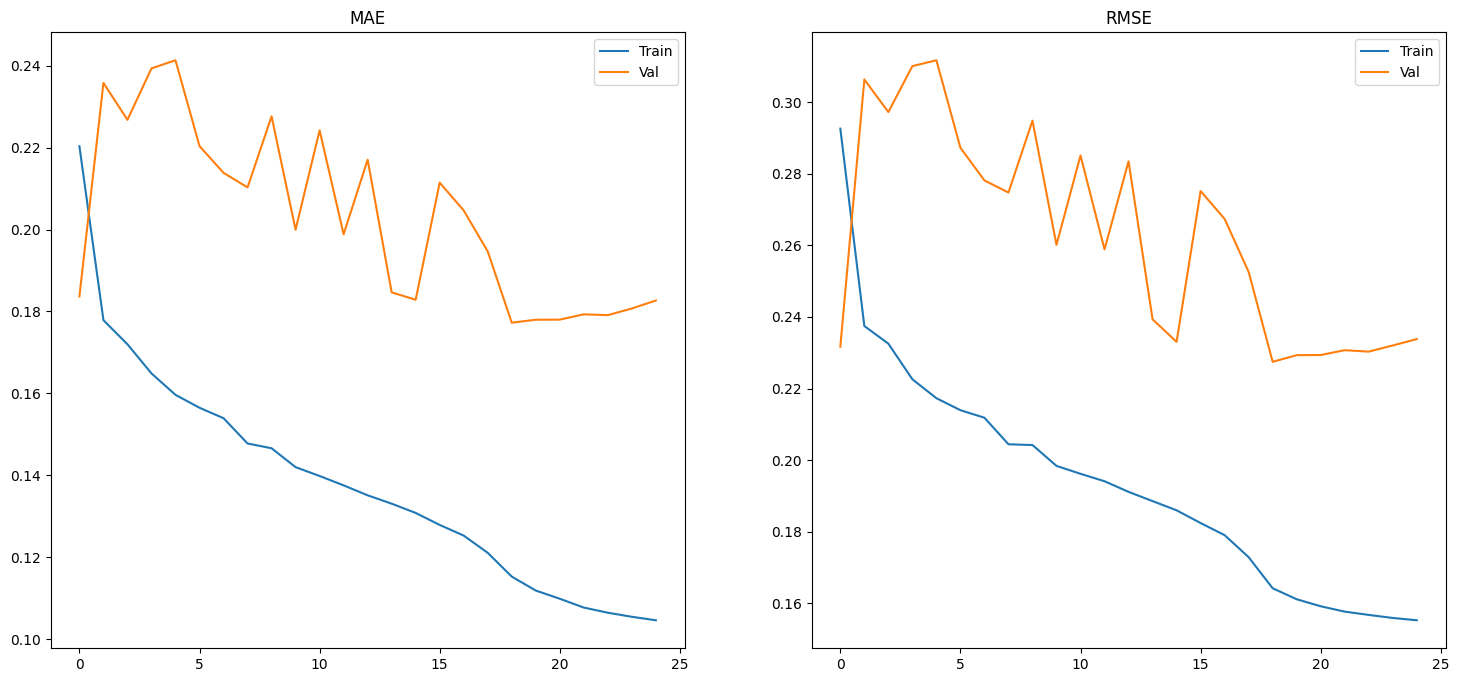

In [62]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Val')
plt.legend()
plt.title("MAE")

plt.subplot(122)
plt.plot(hist.history['root_mean_squared_error'], label='Train')
plt.plot(hist.history['val_root_mean_squared_error'], label='Val')
plt.legend()
plt.title("RMSE")
plt.show()

In [63]:
model.evaluate(test_data)

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - loss: 0.1767 - root_mean_squared_error: 0.2258


[0.17534463107585907, 0.22627361118793488]

Metrik yang digunakan pada training model adalah Root Mean Squared Error. Metrik tersebut menggambarkan seberapa jauh hasil prediksi dengan nilai sebenarnya dengan menghitung kuadrat dari rata-rata selisih prediksi dan nilai sebenarnya. Rumus yang digunakan adalah sebagai berikut.

$$RMSE = \sqrt[]{\frac{\sum_{i=1}^n(\hat{Y_i} - Y_i)^2}{n}}$$

Keterangan :


$\hat{Y_i} : $ Prediksi ke-i

$Y_i$ : Nilai ke-i

$n$ : Jumlah data